In [15]:
import collections
import math
import os
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


In [16]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)


def read_data(filename):
    ''' zip 파일에 포함된 텍스트 파일을 읽어서 단어 리스트 생성. 포함된 파일은 1개. 
    zip 파일은 30mb, txt 파일은 100mb. '''
    with zipfile.ZipFile(filename) as f:
        names = f.namelist()                # ['text8']
        contents = f.read(names[0])         # 크기 : 100,000,000바이트
        text = tf.compat.as_str(contents)   # 크기 : 100,000,000
        return text.split()                 # 갯수 : 17005207


vocabulary = read_data(filename)
print('Data size', len(vocabulary))   

# .을 기준으로 리스트 여러개로 나눈후에 space로 다시 리스트로 나눈다.
# I like you. you like me -> [[I like you], [you like me]] -> [[[I] [like] [you]], ... ]

Found and verified text8.zip
Data size 17005207


In [17]:
def word_numbering(vocabulary, number_of_n_words=50000):
    """
    Arguments:
    vocabulary -- a list of words you want to train the word2vec
    number_of_n_words -- number of most frequent n words in the vocabulary you want to set
    
    Returns:
    int_voc -- a list of vocabulary that is mapped into integer-valeud index
    word_to_int -- python dict mapping words in the vocabulary into an integer-valued index
    int_to_word -- python dict mapping integer-valued index to words
    most_frequent_n_words -- a list with pairs of n most frequent words with its frequency -> [(word, frequency)]
    """
    word_count = collections.Counter(vocabulary)
    most_frequent_n_words = word_count.most_common(number_of_n_words - 1)
            
    word_to_int = {'UNK': 0} # set 0 as unknown token
    for word, _ in most_frequent_n_words:
        word_to_int[word] = len(word_to_int)
    
    int_to_word = {v: k for k, v in word_to_int.items()} # reverse dict of word_to_int


    count = 0
    int_voc = []

    for word in vocabulary:
        if word in word_to_int: # if word is in n most frequent words
            int_voc.append(word_to_int[word]) #. change the word into the corresponding integer
        else:
            int_voc.append(0) # not in the n most frequent word.
            count += 1   # number of words that are not in n most frequent words
 
    most_frequent_n_words.insert(0, ('UNK', count))
    #most_frequent_n_words = np.insert(most_frequent_n_words, 0,('UNK', count),axis=0)
            
    return int_voc, list(word_to_int.keys()), most_frequent_n_words
    
# del vocabulary

In [18]:
data, ordered_words, most_frequent_n_words = word_numbering(vocabulary)

In [19]:
def compute_f(most_frequent_n_words):
    """
    Computing the portion of each word from most_frequent_n_words
    parameter passing이 문제가 될시 most_frequent_n_words를 passing 하지않고 사용할 수도 있을 것 같다.
    Arguments:
    most_frequent_n_words -- a list of most frequent words, length of "vocabulary_size" 
                             with tuple [(word, word_frquency), ...]
    
    Returns:
    divided_frequency -- a numpy array containing the word_frequency in descending order, size of (vocabulary_size, )
    """
    list_to_numpy = np.array(most_frequent_n_words)
    divided_words = list_to_numpy[:, 0]
    divided_frequency = list_to_numpy[:, 1].astype(np.int)
    sum_frquency = np.sum(divided_frequency)
    assert ( sum_frquency.shape == ())
    divided_frequency = divided_frequency / sum_frquency
    
    
    
    return divided_frequency

In [8]:
divided_frequency = compute_f(most_frequent_n_words) # 필요한 코드 지우지말자

In [9]:
def subsampling(divided_frequency,  t=0.00001):
    """
    Arguments:
    divided_frequency -- a numpy array of the frequency of each word, shape of (vocabulary_size,)
    t -- threshold 
    
    Returns:
    p_w -- a numpy array of probability of dropping each word, shape of (vocabulary_size, )
    """
    p_w = (divided_frequency - t )/divided_frequency - np.sqrt(t / divided_frequency)
    p_w[p_w < 0] = 0
    assert (p_w.shape == divided_frequency.shape)
    
    return p_w

In [10]:
def noise_distribution(divided_frequency):
    """
    Used in negative sampling, the probabiltiy of choosing n negative samples
    Arguments:
    divided_frequency -- a numpy array of the frequency of each word, shape of (vocabulary_size,)

    Returns:
    neg_p_w: a numpy array of probability of each words in most_frequent_n_words, shape of (vocabulary_size, )
    """
    f = np.power(divided_frequency, 0.75)
    neg_p_w = f/ sum(f)
    return neg_p_w

In [11]:
divided_frequency

array([  2.46036993e-02,   6.24159412e-02,   3.49114833e-02, ...,
         5.29249659e-07,   5.29249659e-07,   5.29249659e-07])

In [12]:
noise = (noise_distribution(divided_frequency)) # 필요한 코드 지우지말자 

In [13]:
def create_mini_batch(int_voc, batch_size, window_size, data_index, sentence_index):
    """
    Create a mini batch of (target word, context word) for training
    
    Arguments:
    int_voc -- a list of vocabulary that is mapped into integer-valued index
    batch_size -- size of batch in stochastic gradient descent # will be 1 
    window_size -- size of window around the target word.
    data_index -- the index of the target word
    sentence_index -- will be implemented if the data set is changed.
    
    Returns:
    batch --  a numpy array ofthe index of the target word
    labels -- a numpy array of the index of the context word
    data_index -- the next index of the target word
    """
    data_index = data_index % len(int_voc)
    int_voc = int_voc # this will deleted if the input includes punctuation
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size), dtype=np.int32)
    
    # start index and the end index of windows 
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(int_voc)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))
    context_index = np.random.choice(num_range)
    
    for i in range(batch_size): # may need change
        batch[i] = data[data_index]
        labels[i] = data[context_index]
    
    data_index = (data_index + 1) % len(int_voc) # need to be changed if the data set is changed
    
    return batch, labels, data_index

In [212]:
batch, labels, data_index = create_mini_batch(data, batch_size=1, window_size=3, data_index=0, sentence_index=0)
print(data_index)
for i in range(1):
    print('{} {} -> {} {}'.format(batch[i],     ordered_words[batch[i]],
                                  labels[i], ordered_words[labels[i]]))

1
5234 anarchism -> 6 a


In [15]:
def parameter_initialization(vocabulary_size, projection_size):
    """
    Initialization method -- he initialization. 
    
    Argument:
    vocabulary_size -- size of the vocabulary
    projection_size -- the dimension of hidden layer in NN
    
    Return:
    parameters -- a python dictionary containing weights 
                         -- W_in, size of (vocabulary_size, projection_size)
                         -- W_out, size of (projection_size, vocabulary_size)
    """
    
    np.random.seed(0)
    parameters = {}
    
    parameters['W_in'] = np.random.randn(vocabulary_size, projection_size) *  np.sqrt(2 / vocabulary_size) 
    
    parameters['W_out'] = np.random.randn(projection_size, vocabulary_size) *  np.sqrt(2 / projection_size)
    
    assert (parameters['W_in'].shape == (vocabulary_size, projection_size)) 
    assert (parameters['W_out'].shape == (projection_size, vocabulary_size))
    
        
    return parameters

In [16]:
def sigmoid(z):
    """
    sigmoid function
    
    Arguments:
    Z -- a numpy array of any shape
    
    Returns:
    sig -- a numpy array of sigmoid(z)
    """
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [17]:
def compute_cost(batch, labels, parameters, is_pos):
    """
    Arguments:
    batch -- the index of the target word 
    labels -- the indexes of the context words
    parameters -- a python dictionrary containing W_in and W_out, used to calcuate the part of cost function
    is_pos -- if "pos", compute np.multiply(out, hidden), if "neg" compute -np.multiply(out, hidden)
    
    Returns:
    cost -- a partial cost for feed_forward_NN
    """
    assert(batch.shape==labels.shape)
    W_in = parameters["W_in"]
    W_out = parameters["W_out"]
    
    hidden = W_in.T[:,batch]
    out = W_out[:, labels]
    if is_pos == "pos":
        cost = np.sum(np.multiply(out, hidden),axis=0)
    elif is_pos == "neg":
        cost = - np.sum(np.multiply(out, hidden),axis=0)
    cost = sigmoid(cost)
    cost = -np.log(cost)
    
    assert (hidden.shape == (W_in.shape[1], len(batch)))
    assert (out.shape == (W_in.shape[1], len(batch)))
    assert (cost.shape == (len(batch),))
    
    return cost

In [18]:
def feed_forward_NN(batch, labels, k, parameters):
    """    
    Compute the cost function for Word2vec and returns the cost and the index of negative samples
    
    Arguments:
    batch-- a numpy array contaring the input of Neural Network of shape (batch_size, ) size = 1 로 가정하자
    labels -- a numpy array containing the true labeled output of shape (batch_size, )
    k -- number of negative sampling
    parameters -- python dictionary containing weights W_in, W_out
    
    Returns:
    cost -- the cost function of the NN
    negs -- a numpy array containing the indexes of negative samples
    """
    positive = compute_cost(batch, labels, parameters, "pos")
    for i, label_word in enumerate(batch):            
        negative_samples = np.random.choice(np.arange(0,50000), k, p=noise) # changed to noise distribution 
        neg_batch = np.array([label_word for _ in range (k)])
        negs = negative_samples # batch size가 바뀌면 수정되야하는 부분
        
        assert (negative_samples.shape == neg_batch.shape)
        
        neg = np.sum(compute_cost(neg_batch, negative_samples, parameters, "neg"))
        positive[i] = positive[i] + neg 
        
    cost = np.mean(positive)
    assert(cost.shape == ())
    return cost, negs

# negative sampling 도 return 해야 할것 같다? ?


In [19]:
def backpropagation(batch, labels, negs, parameters, learning_rate=0.01):
    """
    calculates the backpropagation and updates the parameters 
    
    Arguments:
    batch -- a numpy array containing the index of the batch
    labels -- a numpy array containing the index of the label
    negs -- a numpy array containng the indexes of negative samples 
    parameters -- a python dictonary containing numpy array parameters that are needed to be updated.
                   -- W_in, shape of (vocabulary_size, projection_size) 
                   -- W_out, shape of (projection_size, vocabulary_size)
    learning rate -- an integer, learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containing updated parameters containing W_in and W_out
    """
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    hidden = W_in.T[:, batch] # shape: (100, 1)
    
    out = W_out[:, labels] # shape: (100,1)
    neg_out = W_out[:, negs] # shape: (100, k)
    
    k = len(negs)
    
    out_sig = sigmoid(np.sum(np.multiply(out, hidden),axis=0)) - 1
    out_neg_sig = sigmoid(np.sum(np.multiply(neg_out, hidden),axis=0, keepdims=True)) 
    
    assert(out_neg_sig.shape == (1, k))
    s = np.sum(out_neg_sig * neg_out, axis=1, keepdims=True)
    t = np.multiply(out_sig, out)
    assert(s.shape==t.shape)
    grads_in = s+t
    
    grads_out = (out_sig) * hidden  # hidden (100, 1)
    grads_neg_out = (out_neg_sig) *  hidden
            
    # update should be done at the same time 
    W_in[batch,:] = W_in[batch,:] - learning_rate * grads_in.T
    W_out[:, labels] = W_out[:, labels] - learning_rate * grads_out
    W_out[:, negs] = W_out[:, negs] - learning_rate * grads_neg_out
    
    return parameters

In [20]:
def train(vocabulary, projection_size, vocabulary_size, epoch, training_time, learning_rate):
    """
    Arguments:
    vocabularary -- a list of data set
    projection_size -- the projection size of a neural network
    vocabulary_size -- used to limit the size of vocabulary 
    epoch -- number of epoches in training the network
    training time -- number of iterations in each epoch -- 구현이 끝나면 빼야한다.
    learning rate -- learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containg trained parameters W_in and W_out
    """
    parameters = parameter_initialization(vocabulary_size, projection_size)
    
  #  data, ordered_words, most_frequent_n_words = word_numbering(vocabulary, vocabulary_size)

    for j in range(epoch):
        data_index = 0
        
        for i in range(training_time):
            batch, labels, data_index = create_mini_batch(data, batch_size=1, window_size=3, data_index=data_index,
                                                          sentence_index=0)
            cost, negs = feed_forward_NN(batch,labels, 20, parameters)
            # learning_rate = learning_rate / (1 + 0.01* epcoh_num) 
            parameters = backpropagation(batch, labels, negs, parameters, learning_rate)

            if i % 1000000 == 0:
                print("The cost at:", i,"th iteration is",cost)

    return parameters

In [213]:
mini_parameters=train(vocabulary, 300, 50000, 1, 1000, 0.1) # parameters=train(vocabulary, 300, 50000, 3, 17000000, 0.1) 

The cost at: 0 th iteration is 14.532962223


In [26]:
parameters=train(vocabulary, 300, 50000, 1, 1000000, 0.1) # parameters=train(vocabulary, 300, 50000, 3, 17000000, 0.1) 

The cost at: 0 th iteration is 14.532962223
The cost at: 1000000 th iteration is 5.76393485519
The cost at: 2000000 th iteration is 2.98237175843
The cost at: 3000000 th iteration is 0.865450175073
The cost at: 4000000 th iteration is 5.4519366114
The cost at: 5000000 th iteration is 4.23380880487
The cost at: 6000000 th iteration is 3.47074348484
The cost at: 7000000 th iteration is 4.54649290677
The cost at: 8000000 th iteration is 0.575478034133
The cost at: 9000000 th iteration is 2.40761529522
The cost at: 10000000 th iteration is 2.54031889636
The cost at: 11000000 th iteration is 3.22661280975
The cost at: 12000000 th iteration is 4.20263881934
The cost at: 13000000 th iteration is 4.3529601316
The cost at: 14000000 th iteration is 2.54972330493
The cost at: 15000000 th iteration is 1.59263775585
The cost at: 16000000 th iteration is 5.06807146445
The cost at: 0 th iteration is 4.67868465723
The cost at: 1000000 th iteration is 2.56758401412
The cost at: 2000000 th iteration is 

In [29]:
final_embeddings = parameters['W_in']

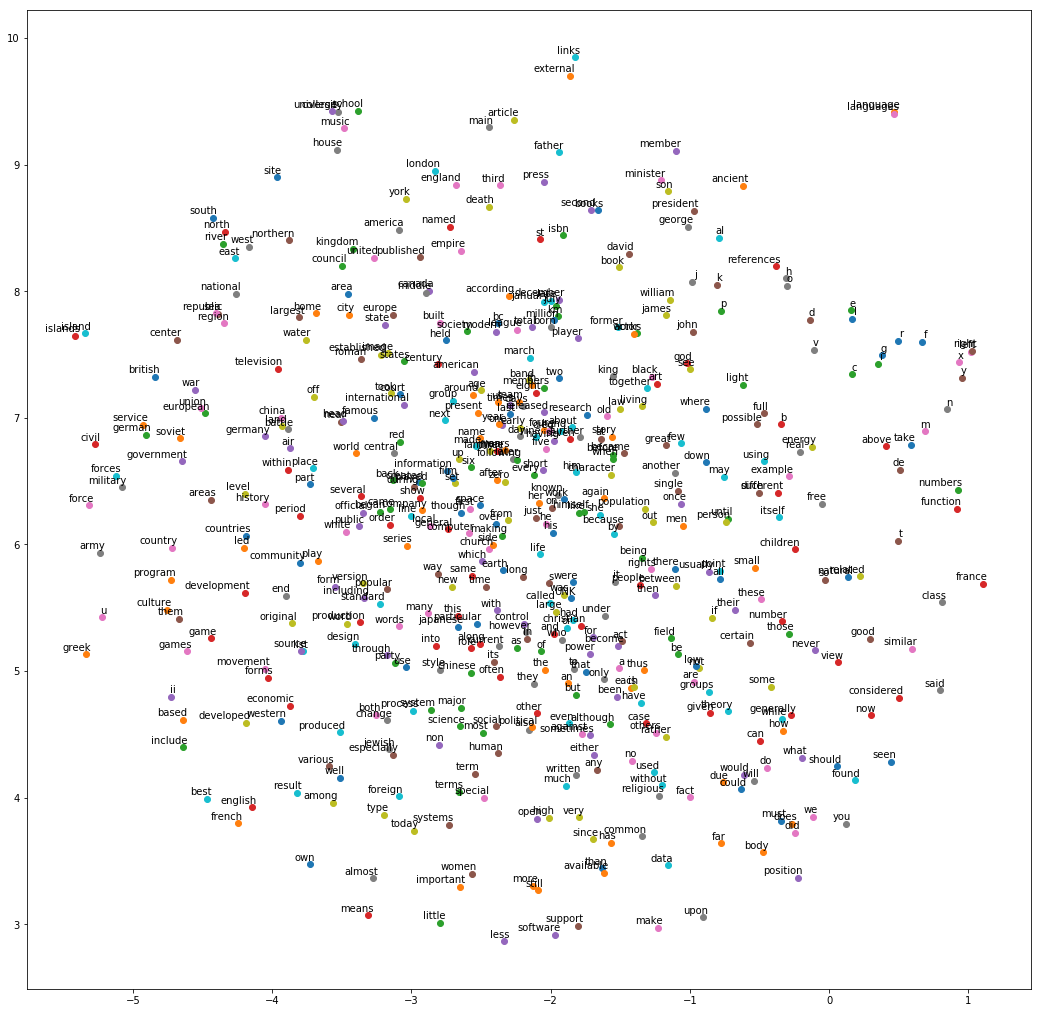

In [30]:
# Step 6: embeddings 시각화

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 원본 코드.
    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # 재구성한 코드
    # for (x, y), label in zip(low_dim_embs, labels):
    #     plt.scatter(x, y)
    #     plt.annotate(label,
    #                  xy=(x, y),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # low_dim_embs 내부 갯수와 n_components가 같아야 한다.
    # n_components : 차원. default는 2.
    # perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
    # n_iter : 최적화에 사용할 반복 횟수. 최소 200. default는 1000.
    # init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수. 50000개의 embeddings로부터 앞쪽 일부만 사용.
    # low_dim_embs에는 변환된 좌표 x, y가 들어있다.
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드
    # labels = [ordered_words[i] for i in range(plot_only)]             # 원본 코드

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')


In [ ]:
final_embeddings

## Softmax Algorithm

In [173]:
def create_mini_batch_softmax(int_voc, batch_size, window_size, data_index, sentence_index):
    """
    Create a mini batch of (target word, context word) for training
    
    Arguments:
    int_voc -- a list of vocabulary that is mapped into integer-valued index
    batch_size -- size of batch in stochastic gradient descent # will be 1 
    window_size -- size of window around the target word.
    data_index -- the index of the target word
    sentence_index -- will be implemented if the data set is changed.
    
    Returns:
    batch --  an integer of the index of the target word
    labels -- a numpy array of the index of the context word
    data_index -- the next index of the target word
    """
    data_index = data_index % len(int_voc)
    int_voc = int_voc # this will deleted if the input includes punctuation
    
    batch = np.ndarray(shape=(), dtype=np.int32)
    
    # start index and the end index of windows 
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(int_voc)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))
    
    labels = np.ndarray(shape=(len(num_range)), dtype=np.int32)
    batch = data[data_index]

    for i, index in enumerate(num_range): # may need change
        labels[i] = data[index]
    
    data_index = (data_index + 1) % len(int_voc) # need to be changed if the data set is changed
    
    return batch, labels, data_index

In [174]:
batch, labels, data_index = create_mini_batch_softmax(data, batch_size=1, window_size=3, data_index=3, sentence_index=0)
print(data_index)
for i in range(len(labels)):
    print('{} {} -> {} {}'.format(batch,     ordered_words[batch],
                                  labels[i], ordered_words[labels[i]]))

4
6 a -> 5234 anarchism
6 a -> 3081 originated
6 a -> 12 as
6 a -> 195 term
6 a -> 2 of
6 a -> 3134 abuse


In [175]:
def softmax(x):
    """
    Arguments:
    x -- input of (n, ) 
    
    Returns:
    softmax(x) -- the value of softmax
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [198]:
def feed_forward_softmax(batch, labels, parameters):

    cache = {}
    loss = 0
    W_in = parameters["W_in"]
    W_out = parameters["W_out"]
    nb_classes = W_in.shape[0]
    targets = np.array([labels]).reshape(-1)
    context = np.eye(nb_classes)[targets]
    
    targets_batch = np.array([batch]).reshape(-1)
    batch_one_hot = np.eye(nb_classes)[targets_batch].reshape(W_in.shape[0],)
    
    
    hidden = W_in.T[:,batch]
    u = np.dot(W_out.T, hidden)
    y_pred = softmax(u)
    
    cache['batch_one_hot'] = batch_one_hot
    cache['hidden'] = hidden
    cache['context'] = context
    cache['u'] = u
    cache['y_pred'] = y_pred
    
    
    loss += -np.sum([u[label == 1] for label in context]) + len(context) * np.log(np.sum(np.exp(u)))
    
    return loss, cache

In [199]:
def backpropagation_softmax(batch, labels, cache, parameters,  learning_rate=0.01):
    """
    calculates the backpropagation and updates the parameters 
    
    Arguments:
    batch -- a numpy array containing the index of the batch
    labels -- a numpy array containing the index of the label
    parameters -- a python dictonary containing numpy array parameters that are needed to be updated.
                   -- W_in, shape of (vocabulary_size, projection_size) 
                   -- W_out, shape of (projection_size, vocabulary_size)
    learning rate -- an integer, learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containing updated parameters containing W_in and W_out
    """
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    
    batch_one_hot = cache['batch_one_hot']
    hidden = cache['hidden']
    context = cache['context']
    u = cache['u']
    y_pred = cache['y_pred']
    
    e = np.array([-label + y_pred.T for label in context])
    grads_out = np.outer(hidden, np.sum(e, axis=0))
    grads_in = np.outer(batch_one_hot, np.dot(W_out, np.sum(e, axis=0).T))
    
    # update should be done at the same time 
    W_in = W_in - learning_rate * grads_in
    W_out = W_out - learning_rate * grads_out
    
    return parameters

In [200]:
p = parameter_initialization(50000,300)
a, cache = feed_forward_softmax(batch,labels, parameters=p)
backpropagation_softmax(batch,labels,  cache, p )

{'W_in': array([[  1.11568467e-02,   2.53081640e-03,   6.19008252e-03, ...,
           3.68692280e-03,  -2.52633748e-03,   2.34043893e-03],
        [ -8.26320135e-03,   1.04869392e-02,  -7.47335040e-04, ...,
          -1.37073018e-03,  -5.88282626e-03,  -1.12949659e-03],
        [ -9.80577616e-03,   2.63935597e-03,  -5.97271076e-03, ...,
          -9.74985479e-03,   1.64085818e-02,  -2.55532459e-03],
        ..., 
        [ -2.19485665e-03,   6.57246923e-03,  -7.49900933e-03, ...,
           1.66020262e-05,  -7.47040740e-03,  -5.18476448e-03],
        [ -1.79777639e-03,   8.04854758e-03,   1.96896788e-04, ...,
          -6.88465556e-03,  -4.25835517e-03,   5.65751272e-03],
        [  3.44435370e-03,   3.26132421e-03,   1.21159200e-04, ...,
           3.40641598e-03,   4.22253571e-03,   9.19264935e-03]]),
 'W_out': array([[-0.04148528,  0.11805329,  0.13869866, ...,  0.07064317,
          0.01292566, -0.01193744],
        [-0.06620975, -0.07011239,  0.0812018 , ..., -0.0188462 ,
       

In [209]:
def train_softmax(vocabulary, projection_size, vocabulary_size, epoch, training_time, learning_rate):
    """
    Arguments:
    vocabularary -- a list of data set
    projection_size -- the projection size of a neural network
    vocabulary_size -- used to limit the size of vocabulary 
    epoch -- number of epoches in training the network
    training time -- number of iterations in each epoch -- 구현이 끝나면 빼야한다.
    learning rate -- learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containg trained parameters W_in and W_out
    """
    parameters = parameter_initialization(vocabulary_size, projection_size)
  #  data, ordered_words, most_frequent_n_words = word_numbering(vocabulary, vocabulary_size)

    for j in range(epoch):
        data_index = 0
        
        for i in range(training_time):
            batch, labels, data_index = create_mini_batch_softmax(data, batch_size=1, window_size=1, data_index=data_index,
                                                          sentence_index=0)
            cost, cache = feed_forward_softmax(batch,labels, parameters)
            # learning_rate = learning_rate / (1 + 0.01* epcoh_num) 
            parameters = backpropagation_softmax(batch, labels, cache, parameters, learning_rate)

            if i % 100 == 0:
                print("The cost at:", i,"th iteration is",cost)

    return parameters

In [211]:
parameters_softmax=train_softmax(vocabulary, 300, 50000, 1, 1000, 0.1) # parameters=train(vocabulary, 300, 50000, 3, 17000000, 0.1) 

The cost at: 0 th iteration is 10.8062823333
The cost at: 100 th iteration is 21.6366157521
The cost at: 200 th iteration is 21.6387093212
The cost at: 300 th iteration is 21.6370602035
The cost at: 400 th iteration is 21.6732385735
The cost at: 500 th iteration is 21.6458269024
The cost at: 600 th iteration is 21.6340596056
The cost at: 700 th iteration is 21.6562124105
The cost at: 800 th iteration is 21.6507764171
The cost at: 900 th iteration is 21.6313260139


## Hierarchical Softmax

In [172]:
vocabulary_size = 50000

In [234]:
def sigmoid_hs(z):
    """
    sigmoid function
    
    Arguments:
    Z -- a numpy array of any shape
    
    Returns:
    sig -- a numpy array of sigmoid(z)
    """
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [235]:
# 기존의 create_mini_batch_softmax와 동일한 함수입니다.
def create_mini_batch_Hierarchical(int_voc, batch_size, window_size, data_index, sentence_index):
    """
    Create a mini batch of (target word, context word) for training
    
    Arguments:
    int_voc -- a list of vocabulary that is mapped into integer-valued index
    batch_size -- size of batch in stochastic gradient descent # will be 1 
    window_size -- size of window around the target word.
    data_index -- the index of the target word
    sentence_index -- will be implemented if the data set is changed.
    
    Returns:
    batch --  an integer of the index of the target word
    labels -- a numpy array of the index of the context word
    data_index -- the next index of the target word
    """
    data_index = data_index % len(int_voc)
    int_voc = int_voc # this will deleted if the input includes punctuation
    
    batch = np.ndarray(shape=(), dtype=np.int32)
    
    # start index and the end index of windows 
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(int_voc)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))
    
    labels = np.ndarray(shape=(len(num_range)), dtype=np.int32)
    batch = data[data_index]

    for i, index in enumerate(num_range): # may need change
        labels[i] = data[index]
    
    data_index = (data_index + 1) % len(int_voc) # need to be changed if the data set is changed
    
    return batch, labels, data_index

In [236]:
batch, labels, data_index = create_mini_batch_Hierarchical(data, batch_size=1, window_size=3, data_index=3, sentence_index=0)
print(data_index)
for i in range(len(labels)):
    print('{} {} -> {} {}'.format(batch,     ordered_words[batch],
                                  labels[i], ordered_words[labels[i]]))

4
6 a -> 5234 anarchism
6 a -> 3081 originated
6 a -> 12 as
6 a -> 195 term
6 a -> 2 of
6 a -> 3134 abuse


In [123]:
huffman_code = []

In [148]:
def huffman_tree():
    count = [0] * (2 * vocabulary_size + 1)
    binary = [0] *(2 * vocabulary_size + 1)
    parent_node = [0] * (2 * vocabulary_size + 1)
    for i in range (vocabulary_size):
        count[i] = most_frequent_n_words[i][1]
    for i in range(vocabulary_size, 2 * vocabulary_size):
        count[i] = 1e15
    pos1 = vocabulary_size -1
    pos2 = vocabulary_size
    min1i = 0
    min2i = 0
    for a in range(vocabulary_size -1):
        if pos1 >= 0:
            if count[pos1] < count[pos2]:
                min1i = pos1
                pos1 -= 1
            else:
                min1i = pos2
                pos2 += 1
        else:
            min1i = pos2
            pos2 += 1
        if pos1 >= 0:
            if count[pos1] < count[pos2]:
                min2i = pos1
                pos1 -= 1
            else:
                min2i = pos2
                pos2 += 1
        else:
            min2i = pos2
            pos2 += 1
        count[vocabulary_size + a] = count[min1i] + count[min2i]
        parent_node[min1i] = vocabulary_size + a
        parent_node[min2i] = vocabulary_size + a
        binary[min2i] = 1 # 오른쪽이 1
    
    for a in range(vocabulary_size):
        code = ""
        b = a
        i = 0
        while(True):
            b_prime = str(int(binary[b]))
            code += b_prime
            i += 1
            b = parent_node[b]
            if b == (vocabulary_size* 2 - 2):
                break
        code = code[::-1]
        huffman_code.append(code)

In [149]:
huffman_tree()

In [167]:
import queue

class HuffmanNode(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right
        self.weight = np.random.randn(300,1) *  np.sqrt(2 /50000)
    def children(self):
        return((self.left, self.right))
    def __eq__(self, a):
        return 1

freq = [(t[1], t[0]) for t in most_frequent_n_words]
def create_tree(frequencies):
    p = queue.PriorityQueue()
    for value in frequencies:    # 1. Create a leaf node for each symbol
        p.put(value)             #    and add it to the priority queue
    while p.qsize() > 1:         # 2. While there is more than one node
        l, r = p.get(), p.get()  # 2a. remove two highest nodes
        node = HuffmanNode(l, r) # 2b. create internal node with children
        p.put((l[0]+r[0], node)) # 2c. add new node to queue      
    return p.get()               # 3. tree is complete - return root node

node = create_tree(freq)
print(node)

# Recursively walk the tree down to the leaves,
#   assigning a code value to each symbol
def walk_tree(node, prefix="", code={}):
    if isinstance(node[1].left[1], HuffmanNode):
        walk_tree(node[1].left,prefix+"0", code)
    else:
        code[node[1].left[1]]=prefix+"0"
    if isinstance(node[1].right[1],HuffmanNode):
        walk_tree(node[1].right,prefix+"1", code)
    else:
        code[node[1].right[1]]=prefix+"1"
    return(code)


    
    
code = walk_tree(node)
for i in sorted(freq, reverse=True):
    print(i[1], '{:6.2f}'.format(i[0]), code[i[1]])

(17005207, <__main__.HuffmanNode object at 0x1822de7470>)
the 1061396.00 1001
of 593677.00 10111
UNK 418391.00 00101
and 416629.00 00100
one 411764.00 00010
in 372201.00 111100
a 325873.00 110101
to 316376.00 110011
zero 264975.00 100010
nine 250430.00 011101
two 192644.00 1111110
is 183153.00 1110111
as 131815.00 1000011
eight 125285.00 0111100
for 118445.00 0110001
s 116710.00 0101110
five 115789.00 0101100
three 114775.00 0101001
was 112807.00 0100110
by 111831.00 0100011
that 109510.00 0011111
four 108182.00 0011100
six 102145.00 0001100
seven 99683.00 0000011
with 95603.00 11111010
on 91250.00 11101100
are 76527.00 11000100
it 73334.00 10110011
from 72871.00 10110001
or 68945.00 10100101
his 62603.00 01110011
an 61925.00 01110000
be 61281.00 01101100
this 58832.00 01011111
which 54788.00 01000001
at 54576.00 00111101
he 53573.00 00110110
also 44358.00 111001110
not 44033.00 111001011
have 39712.00 110100000
were 39086.00 110010010
has 37866.00 110000011
but 35358.00 101010110
othe

complete 2561.00 1101101011011
significant 2554.00 1101100100101
parliament 2554.00 1101100100100
actually 2553.00 1101100100011
business 2542.00 1101001111101
fiction 2540.00 1101001111010
physical 2539.00 1101001111001
followed 2537.00 1101001111000
deaths 2530.00 1101001110000
key 2527.00 1101001100101
widely 2525.00 1101001011111
leader 2525.00 1101001011110
page 2520.00 1101001011001
basic 2519.00 1101001011000
types 2518.00 1101001010111
henry 2494.00 1101000100110
elected 2493.00 1101000100101
beginning 2493.00 1101000100011
fire 2489.00 1101000011110
building 2480.00 1100101110101
independence 2478.00 1100101110010
went 2475.00 1100101101111
movie 2471.00 1100101101010
aircraft 2471.00 1100101101001
ever 2470.00 1100101100101
canadian 2468.00 1100101100011
material 2464.00 1100101010101
births 2462.00 1100101001110
video 2461.00 1100101001101
news 2458.00 1100101001011
future 2457.00 1100101000111
scientific 2456.00 1100101000110
simply 2454.00 1100101000000
go 2451.00 11001001

summer 1520.00 11111111100001
necessary 1518.00 11111111010111
intended 1518.00 11111111010110
miles 1515.00 11111111001011
calendar 1515.00 11111111001010
animal 1515.00 11111111001001
remain 1513.00 11111111000000
internal 1509.00 11111110110011
disease 1509.00 11111110110010
wars 1505.00 11111110010101
convention 1505.00 11111110010100
worked 1504.00 11111110010000
flight 1502.00 11111011111100
round 1498.00 11111011011101
kind 1496.00 11111011010011
acts 1496.00 11111011010001
reading 1495.00 11111011010000
multiple 1495.00 11111011001111
physics 1492.00 11111001110111
labour 1492.00 11111011000101
users 1491.00 11111001110101
speaking 1491.00 11111001110100
signed 1490.00 11111001110010
brown 1490.00 11111001101111
critical 1489.00 11111001101101
sir 1488.00 11111001100001
mathematical 1487.00 11111001100000
bridge 1487.00 11111001001111
billion 1486.00 11111001001110
sets 1485.00 11111001001100
translation 1484.00 11111001001001
regarded 1483.00 11111000111011
branch 1475.00 1111

flow 1054.00 10100000100001
category 1054.00 10100000111000
soldiers 1051.00 10100000010001
genetic 1051.00 10100000010000
reports 1050.00 10100000001000
os 1050.00 10001111111100
opened 1050.00 10001111111110
leaving 1050.00 10001111111011
territories 1049.00 10001111110001
mac 1049.00 10001111110000
holds 1049.00 10001111101011
step 1047.00 10001111011000
jackson 1047.00 10001111010111
algorithm 1047.00 10001111010110
truth 1044.00 10001110111010
stop 1044.00 10001111000010
theorem 1043.00 10001110101111
reality 1043.00 10001110101110
room 1042.00 10001110011110
fell 1042.00 10001110011101
origins 1041.00 10001110010011
instrument 1041.00 10001110010010
effort 1041.00 10001110010001
crown 1041.00 10001110011001
care 1041.00 10001110010000
bob 1041.00 10001110001111
defeated 1040.00 10001110000110
democracy 1037.00 10001101011101
picture 1036.00 10001101011011
permanent 1036.00 10001101011001
hence 1036.00 10001101011010
concepts 1036.00 10001101011000
nazi 1034.00 10001101001001
prot

colony 759.00 111111110110101
agent 759.00 111111110110100
separated 758.00 111111110100110
extension 758.00 111111110100101
coach 758.00 111111110100100
cabinet 758.00 111111110100011
visual 757.00 111111110010000
scott 757.00 111111110100000
forum 757.00 111111110000011
coalition 757.00 111111110000010
suggests 756.00 111111101110000
periods 756.00 111111101110111
employed 756.00 111111101111101
dominated 756.00 111111101110100
davis 756.00 111111101110110
adult 756.00 111111101111110
reputation 755.00 111111101101101
hero 755.00 111111101101100
looking 754.00 111111100111010
literally 754.00 111111100111111
selection 753.00 111111100110101
males 753.00 111111100110100
existed 753.00 111111100110011
entitled 753.00 111111100110010
defence 753.00 111111100110001
changing 753.00 111111100110000
subjects 752.00 111111100000111
grammar 752.00 111111100010101
alfred 752.00 111111100010000
younger 751.00 111110111110111
interview 751.00 111110111110110
stable 750.00 111110111110101
opinion

goddess 617.00 110010110010011
agents 617.00 110010110010010
chess 616.00 110010101010001
bacteria 616.00 110010110001000
assistance 616.00 110010101011101
airlines 616.00 110010101010000
testing 615.00 110010100111100
researchers 615.00 110010100110001
ip 615.00 110010100110000
documentary 615.00 110010100101011
theoretical 614.00 110010100010110
ll 614.00 110010100000111
hole 614.00 110010100000110
gary 614.00 110010100010011
en 614.00 110010011111101
aim 614.00 110010100010010
supposed 613.00 110010011110101
monster 613.00 110010011110100
delta 613.00 110010011111011
constantine 613.00 110010011111100
columbus 613.00 110010011111010
bound 613.00 110010011111001
piano 612.00 110010011010101
depth 612.00 110010011010100
definitions 612.00 110010011010111
steps 611.00 110010011000000
requirements 611.00 110010001010111
meat 611.00 110010001010110
maria 611.00 110010001110111
legacy 611.00 110010001110110
hindu 611.00 110010001111011
elsewhere 611.00 110010001111010
clubs 611.00 1100100

isolated 511.00 100001000010101
distinctive 511.00 100001000010100
beta 511.00 100001000000111
turning 510.00 100000111111110
speaker 510.00 100001000000110
skill 510.00 100000111100111
morocco 510.00 100000111100110
herself 510.00 100000111111011
herbert 510.00 100001000000010
fighter 510.00 100000111111010
confusion 510.00 100000111110011
compatible 510.00 100000111101110
precise 509.00 100000111010111
manufacturers 509.00 100000111010110
investigation 509.00 100000111010001
electronics 509.00 100000111010000
dragon 509.00 100000111010101
declined 509.00 100000111010100
arithmetic 509.00 100000111000001
turns 508.00 100000110100101
starts 508.00 100000110001100
spin 508.00 100000110101011
liberation 508.00 100000110100100
campbell 508.00 100000110010101
buddhism 508.00 100000111000000
spacecraft 507.00 100000101011011
planets 507.00 100000101011010
messages 507.00 100000101110001
demonstrated 507.00 100000101110000
reduction 506.00 100000101001001
reducing 506.00 100000101001000
prop

raw 412.00 001100100010001
priests 412.00 001100011011000
ph 412.00 001100100010010
marie 412.00 001100011111101
manual 412.00 001100011111100
geneva 412.00 001100100010111
communists 412.00 001100100010110
adoption 412.00 001100011110110
trip 411.00 001100011000100
objective 411.00 001100010101001
membrane 411.00 001100010101000
id 411.00 001100010101111
entering 411.00 001100010101110
conservation 411.00 001100010101011
binding 411.00 001100010101010
aka 411.00 001100010011111
rolling 410.00 001100010010111
paintings 410.00 001100010010110
injury 410.00 001100010011110
errors 410.00 001100010010011
defining 410.00 001100010010001
consensus 410.00 001100010010010
besides 410.00 001100010000111
afc 410.00 001100010010000
weekly 409.00 000111111101101
teach 409.00 000111111101100
neck 409.00 000111111100011
lasted 409.00 000111111100010
desired 409.00 000111111100101
conventions 409.00 000111111100100
arguably 409.00 000111111101011
angel 409.00 000111111101010
wire 408.00 0001111110000

cluster 344.00 1110011000000000
yards 343.00 1110010100100011
realized 343.00 1110010100100010
operational 343.00 1110010100100111
fun 343.00 1110010100100110
convert 343.00 1110010100101101
compete 343.00 1110010100101100
avenue 343.00 1110010100101001
anthem 343.00 1110010100101000
ted 342.00 1110010010110011
shakespeare 342.00 1110010010101010
princeton 342.00 1110010010110000
parks 342.00 1110010010001111
malcolm 342.00 1110010010010010
madrid 342.00 1110010010010101
load 342.00 1110010010110010
literacy 342.00 1110010010110110
lights 342.00 1110010010001100
legally 342.00 1110010010101111
improvements 342.00 1110010010101110
descriptions 342.00 1110010010011101
dancing 342.00 1110010010011000
campaigns 342.00 1110010010110101
alabama 342.00 1110010010011100
victim 341.00 1110010001000100
stack 341.00 1110010001000111
scheduled 341.00 1110010001000110
reserves 341.00 1110010001000011
hosted 341.00 1110010001000010
factbook 341.00 1110010001001101
everyday 341.00 1110010001001100
du

flights 294.00 1100000001001111
epistle 294.00 1100000001100101
ecuador 294.00 1100000001010101
decrease 294.00 1100000001100100
customers 294.00 1100000001101001
cosmic 294.00 1100000001101111
accessible 294.00 1100000001100110
zones 293.00 1100000001000000
xi 293.00 1011011110101101
wasn 293.00 1011011110101100
triangle 293.00 1011011111100001
sized 293.00 1011011101111011
shop 293.00 1011011111100000
reflects 293.00 1011011101111010
psi 293.00 1011011110111001
ois 293.00 1011011110110101
hannibal 293.00 1011011110110100
cornwall 293.00 1011011110110001
commitment 293.00 1011011110110000
commissioned 293.00 1011011110110011
colored 293.00 1011011110110010
collaboration 293.00 1011011110100001
cf 293.00 1011011110100000
burns 293.00 1011011110100101
bitter 293.00 1011011110100100
tons 292.00 1011011100110110
tolkien 292.00 1011011100011011
successive 292.00 1011011011101011
robot 292.00 1011011011111100
nomination 292.00 1011011011100000
morality 292.00 1011011100100100
mapping 292.00

chapel 255.00 1000010000000111
butler 255.00 1000010000000110
brooklyn 255.00 1000001111101101
beneath 255.00 1000001111101100
aims 255.00 1000001111001001
rubber 254.00 1000001101000001
ralph 254.00 1000001101010100
paradise 254.00 1000001100100000
innovation 254.00 1000001101000010
grass 254.00 1000001101001111
grandfather 254.00 1000001100101001
definitive 254.00 1000001101010000
clement 254.00 1000001100011011
attendance 254.00 1000001100011010
powell 253.00 1000000111101010
offense 253.00 1000000111101111
nixon 253.00 1000000111101110
jerome 253.00 1000001010000001
intensity 253.00 1000001010000000
ge 253.00 1000000111111111
flame 253.00 1000000111111110
denotes 253.00 1000000111101101
conductor 253.00 1000000111101100
concentrations 253.00 1000000111101001
competitors 253.00 1000000111101000
combining 253.00 1000001010000111
chronicle 253.00 1000001010000110
bin 253.00 1000000101111011
tuning 252.00 1000000100011111
tobacco 252.00 1000000100011011
ra 252.00 1000000100111001
pursu

sects 229.00 0101111001001100
prompted 229.00 0101111001011111
prey 229.00 0101111001011110
pet 229.00 0101111001000011
metallica 229.00 0101111001000010
impression 229.00 0101111001011001
hermann 229.00 0101111001011000
gambling 229.00 0101101110111111
erected 229.00 0101101110111110
debates 229.00 0101111001001111
arrive 229.00 0101111001001110
ammonia 229.00 0101101110101011
twins 228.00 0101101011100001
susan 228.00 0101101011100000
reich 228.00 0101101101001110
quad 228.00 0101101011110100
prevalent 228.00 0101101100100111
predict 228.00 0101101100001110
np 228.00 0101101100000100
nominal 228.00 0101101100100100
nigeria 228.00 0101101100011001
nicknamed 228.00 0101101101010000
naked 228.00 0101101100011101
mosque 228.00 0101101100100001
minneapolis 228.00 0101101100010000
leonard 228.00 0101101101000101
kid 228.00 0101101100100000
irregular 228.00 0101101011110001
feudal 228.00 0101101011110000
failing 228.00 0101101101001010
faction 228.00 0101101011100101
bet 228.00 010110101110

roof 206.00 0011001000000111
retains 206.00 0011001000000010
resistant 206.00 0011000111101001
ren 206.00 0011000111101000
quarters 206.00 0011001000011001
projection 206.00 0011000111111100
preceded 206.00 0011001000011000
pipe 206.00 0011001000010100
nba 206.00 0011000110100111
mason 206.00 0011000110100110
kepler 206.00 0011001000101011
imperialism 206.00 0011000110100101
iec 206.00 0011000110100100
founders 206.00 0011000111110011
formulated 206.00 0011000111110100
flip 206.00 0011000111110010
exploitation 206.00 0011001000011011
customary 206.00 0011001000011010
cr 206.00 0011000111100111
converts 206.00 0011000111100110
container 206.00 0011000110001011
chronology 206.00 0011000110001010
weakness 205.00 0011000100101011
vancouver 205.00 0011000100101010
township 205.00 0011000100011111
targeted 205.00 0011000100011110
syllables 205.00 0011000100001001
subjective 205.00 0011000100001000
reporter 205.00 0011000100001101
publicity 205.00 0011000100001100
prehistoric 205.00 001100010

cleese 193.00 0000010001011000
cauchy 193.00 0000010001001001
canadians 193.00 0000010001001000
breakdown 193.00 0000010001010101
beating 193.00 0000010001010100
anchorage 193.00 0000001110011001
yields 192.00 0000001010000111
wonder 192.00 0000001010000110
tuned 192.00 0000001100010110
theoretically 192.00 0000001011011001
sullivan 192.00 0000001000010100
sr 192.00 0000000100111111
shoes 192.00 0000001000110000
shaw 192.00 0000001011011000
rituals 192.00 0000001011101001
ratings 192.00 0000001011000101
proceeds 192.00 0000001100010101
pregnant 192.00 0000001010000101
obligation 192.00 0000001100010100
negotiated 192.00 0000001010110100
lengthy 192.00 0000001010000100
keeps 192.00 0000001001101111
jesuit 192.00 0000000111101011
indirectly 192.00 0000001011000100
homeland 192.00 0000000111101010
grains 192.00 0000001010010001
bruno 192.00 0000001010010000
beef 192.00 0000000111001110
accusations 192.00 0000001100000011
taliban 191.00 0000000011001101
rolls 191.00 0000000011101010
owen 1

queensland 176.00 11101001011010101
promising 176.00 11101001011010100
performer 176.00 11101001101111001
observatory 176.00 11101001101111110
lindy 176.00 11101001101111100
isotope 176.00 11101001100011100
inference 176.00 11101001011001111
greg 176.00 11101001101111000
fermentation 176.00 11101001101110011
factories 176.00 11101001101110010
employee 176.00 11101001010111001
elijah 176.00 11101001011001110
beowulf 176.00 11101001100100100
witnessed 175.00 11101000111110000
transitional 175.00 11101000101100111
tissues 175.00 11101000101100110
rhetoric 175.00 11101000101011001
regimes 175.00 11101000101011000
prestige 175.00 11101000101010001
praised 175.00 11101000101010000
organize 175.00 11101000101010111
omitted 175.00 11101000101010110
naples 175.00 11101000101101001
monuments 175.00 11101000101101000
injection 175.00 11101000101001011
humanitarian 175.00 11101000101001010
ham 175.00 11101000101001101
grenada 175.00 11101000101001100
glasgow 175.00 11101000101011101
genera 175.00 

precious 161.00 11011011110010001
perl 161.00 11011011110010000
lotus 161.00 11011011010010101
ivoire 161.00 11011011010010100
gin 161.00 11011011110000101
fundamentally 161.00 11011011010011011
frisian 161.00 11011011010011010
foreigners 161.00 11011011110010101
extraterrestrial 161.00 11011011110010100
exceptional 161.00 11011011110000111
dental 161.00 11011011110000110
curse 161.00 11011011110001011
culminating 161.00 11011011110001010
cookie 161.00 11011011110000011
contacts 161.00 11011011110000010
conclude 161.00 11011011110011001
cartesian 161.00 11011011110011000
breeds 161.00 11011011110010111
arbitration 161.00 11011011110010110
alternating 161.00 11011011010011001
algebras 161.00 11011011010011000
accidentally 161.00 11011011000110001
wolfgang 160.00 11011001111010010
weights 160.00 11011001110111100
treasure 160.00 11011001011111111
ti 160.00 11011010000010001
sinai 160.00 11011010011110110
sharply 160.00 11011010001000110
sauce 160.00 11011010110011011
quit 160.00 11011001

pursuing 145.00 10110110000101001
protons 145.00 10110110000101000
pressing 145.00 10110110001110011
peripheral 145.00 10110110001110010
novelists 145.00 10110110000110011
myself 145.00 10110110000110010
murphy 145.00 10110110001011101
misleading 145.00 10110110001011100
metaphysical 145.00 10110110001001011
martha 145.00 10110110001001010
landlocked 145.00 10110110001101101
indicator 145.00 10110110001101100
illustrations 145.00 10110110001001111
ido 145.00 10110110001001110
hz 145.00 10110110000100101
helena 145.00 10110110000100100
glacial 145.00 10110110001001101
genealogy 145.00 10110110001001100
faso 145.00 10110101111111111
excel 145.00 10110101111111110
ensuing 145.00 10110110000101011
enjoys 145.00 10110110000101010
emancipation 145.00 10110110000110101
echo 145.00 10110110000110100
disagree 145.00 10110110000101111
diagrams 145.00 10110110000101110
ddt 145.00 10110110000110111
conscience 145.00 10110110000110110
confucius 145.00 10110110000101101
confession 145.00 10110110000

advisory 132.00 10100001001010110
yearly 131.00 10100000011000100
worshipped 131.00 10001111011001001
val 131.00 10001111011001000
unite 131.00 10001111011011111
tablets 131.00 10001111011011110
stopping 131.00 10001111101001011
somalia 131.00 10001111101001010
seals 131.00 10001111101010111
rent 131.00 10001111101010110
relational 131.00 10001111100010101
pulling 131.00 10001111100010100
pulitzer 131.00 10001111011011101
peters 131.00 10001111011011100
penis 131.00 10001111011111001
papacy 131.00 10001111011111000
observable 131.00 10001111100001101
narrowly 131.00 10001111100001100
monte 131.00 10001111101010001
moby 131.00 10001111101010000
memoir 131.00 10001111101010101
martyr 131.00 10001111101010100
markup 131.00 10001111101000111
mall 131.00 10001111101000110
lowercase 131.00 10001111011100011
literate 131.00 10001111011100010
kate 131.00 10001111100010111
inputs 131.00 10001111100010110
homogeneous 131.00 10001111101001001
handheld 131.00 10001111101001000
graphite 131.00 1000

maximilian 117.00 01100111000100011
lucifer 117.00 01100111000100010
lorenzo 117.00 01100111010010101
jurisprudence 117.00 01100111010010100
judith 117.00 01100111011000011
joachim 117.00 01100111011000010
humphrey 117.00 01100111010110011
highlights 117.00 01100111010110010
heap 117.00 01100111011011001
halloween 117.00 01100111011011000
graduates 117.00 01100111011010001
garde 117.00 01100111011010000
gaius 117.00 01100111011000001
fisheries 117.00 01100111011000000
filling 117.00 01100111010101001
dre 117.00 01100111010101000
drain 117.00 01100111011010111
dock 117.00 01100111011010110
dell 117.00 01100111010110001
corinth 117.00 01100111010110000
contentious 117.00 01100111011001101
collaborated 117.00 01100111011001100
celsius 117.00 01100111011011111
blessing 117.00 01100111011011110
barton 117.00 01100111011011101
alpine 117.00 01100111011011100
aforementioned 117.00 01100111011010011
affiliation 117.00 01100111011010010
zwingli 116.00 01100100101111001
warmer 116.00 01100100100

chechen 108.00 01000100100011111
cecil 108.00 01000100100011110
captive 108.00 01000100011101101
canyon 108.00 01000100011101100
caliber 108.00 01000100011001001
betty 108.00 01000100011001000
basics 108.00 01000100110111011
arisen 108.00 01000100110000011
afterward 108.00 01000100110111010
activation 108.00 01000100011000001
accusative 108.00 01000100011000000
zodiac 107.00 01000000110011101
ya 107.00 01000000110011100
wrath 107.00 01000000101101101
wiley 107.00 01000000101101100
volatile 107.00 01000000111000001
trolls 107.00 01000000111000000
talked 107.00 01000000111000111
synthesizer 107.00 01000000111000110
swamp 107.00 01000000101100011
stern 107.00 01000000101100010
spirituality 107.00 01000000111001001
shorts 107.00 01000000111001000
scheduling 107.00 01000000110011111
res 107.00 01000000110011110
repetition 107.00 01000000101111011
rationality 107.00 01000000101111000
prohibit 107.00 01000000111010111
polo 107.00 01000000111010110
phonemes 107.00 01000000110010001
paramilitar

discoverer  99.00 00001100010110101
discharged  99.00 00001100010110100
disappearance  99.00 00001100011010101
disabilities  99.00 00001100011010100
defenses  99.00 00001100010000111
crossover  99.00 00001100010000110
correspondent  99.00 00001100010101101
coppola  99.00 00001100010101100
convincing  99.00 00001100001111111
contingent  99.00 00001100001111110
contamination  99.00 00001100011101011
comply  99.00 00001100011101010
commenced  99.00 00001100001111101
cis  99.00 00001100001111100
chemically  99.00 00001100010001111
buck  99.00 00001100010001110
brythonic  99.00 00001100010011001
breakfast  99.00 00001100010011000
borland  99.00 00001100001110101
bonded  99.00 00001100001110100
blonde  99.00 00001100010110011
biochemical  99.00 00001100010110010
bing  99.00 00001100011100101
awakening  99.00 00001100011100100
assured  99.00 00001100010010001
asserting  99.00 00001100010010000
anthropological  99.00 00001100010111111
andersen  99.00 00001100010111110
amp  99.00 00001100011101

basins  91.00 111101011111100011
bald  91.00 111101011111100010
andhra  91.00 111101011111011001
analyzing  91.00 111101011111011000
alveolar  91.00 111101011111100001
alma  91.00 111101011111100000
airplanes  91.00 111101010101010001
wit  90.00 111101000110111000
visibility  90.00 111101000100010001
vera  90.00 111101000100010000
upheld  90.00 111101000110000111
trench  90.00 111101000110000110
trauma  90.00 111101000100010101
toulouse  90.00 111101000100010100
tonnes  90.00 111101000110000101
tails  90.00 111101000110000100
survivor  90.00 111101000100110111
stronghold  90.00 111101000100110110
speculate  90.00 111101000101101111
spans  90.00 111101000101101110
socio  90.00 111101000101000111
slit  90.00 111101000101000110
shipowner  90.00 111101000100111101
shining  90.00 111101000100111100
scientifically  90.00 111101000111001001
scaled  90.00 111101000111001000
safer  90.00 111101001010010001
rewritten  90.00 111101001010010000
qui  90.00 111101000100111011
prototypes  90.00 11110

sacramento  82.00 110111101001011110
ru  82.00 110111101001101001
roller  82.00 110111101001101000
ridges  82.00 110111100111001011
ri  82.00 110111100111001010
restrictive  82.00 110111101010100001
reeves  82.00 110111101010100000
pumps  82.00 110111100111000001
propositional  82.00 110111100111000000
prolog  82.00 110111101001001111
primates  82.00 110111101001001110
premature  82.00 110111100110100101
plenty  82.00 110111100110100100
philippine  82.00 110111100111010111
phased  82.00 110111100111010110
penetrate  82.00 110111100111001111
paganism  82.00 110111100111001110
pads  82.00 110111100111010101
owes  82.00 110111100111010100
oman  82.00 110111100111001001
om  82.00 110111100111001000
nathaniel  82.00 110111100111100001
murals  82.00 110111100111100000
monoid  82.00 110111101100000011
metaphors  82.00 110111101100000010
metamorphosis  82.00 110111101001110111
mercantilism  82.00 110111101001110110
medals  82.00 110111101010100011
mdma  82.00 110111101010100010
lydia  82.00 11

intelligible  75.00 110001011110100101
insignificant  75.00 110001011110100100
immanuel  75.00 110001011101111011
idiot  75.00 110001011101111010
hurricanes  75.00 110001011011111011
https  75.00 110001011011111010
hitter  75.00 110001011101111001
halley  75.00 110001011101111000
halfway  75.00 110001011011101011
guillaume  75.00 110001011011101010
gertrude  75.00 110001011101110101
geologists  75.00 110001011101110100
frontiers  75.00 110001011010111111
fricatives  75.00 110001011010111110
foundational  75.00 110001011011011001
flank  75.00 110001011011011000
feeds  75.00 110001011101001101
fats  75.00 110001011101001100
fare  75.00 110001011100001111
exert  75.00 110001011100001110
excerpt  75.00 110001011010111101
emmanuel  75.00 110001011010111100
emerald  75.00 110001011100001101
embodied  75.00 110001011100001100
educator  75.00 110001011011111001
durable  75.00 110001011011111000
dispersion  75.00 110001011101001011
dispatched  75.00 110001011101001010
det  75.00 110001011110001

enormously  70.00 101011011110101110
engelbart  70.00 101011100010100100
elastic  70.00 101011100010111101
dull  70.00 101011100010111100
downloadable  70.00 101011011110101011
dopamine  70.00 101011011110101010
dominating  70.00 101011100000100001
divergent  70.00 101011100000100000
disagreed  70.00 101011100001011001
devonian  70.00 101011100001011000
deteriorated  70.00 101011100100100100
detained  70.00 101011100110001001
decks  70.00 101011100110001000
dealers  70.00 101011100001100101
consolidate  70.00 101011100001100100
codec  70.00 101011100100110111
clitoris  70.00 101011100100110110
clauses  70.00 101011100101101011
clair  70.00 101011100101101010
catullus  70.00 101011100110000111
catching  70.00 101011100110000110
caesarea  70.00 101011100101101001
cab  70.00 101011100101101000
byrne  70.00 101011100000100101
buyers  70.00 101011100000100100
brainfuck  70.00 101011100001010011
boosted  70.00 101011100000110111
blunt  70.00 101011100000110110
bikes  70.00 101011100100110101

repealed  65.00 100011011110110111
regret  65.00 100011011110110110
reals  65.00 100011100010010111
rb  65.00 100011100010010110
randolph  65.00 100011100010111111
radcliffe  65.00 100011100010111110
putnam  65.00 100011100110000001
provoke  65.00 100011100110000000
procession  65.00 100011100001010001
priori  65.00 100011100001010000
ponty  65.00 100011011110101000
plaintiff  65.00 100011011110100111
pigeon  65.00 100011011110100110
pervasive  65.00 100011010111001011
paints  65.00 100011010111001010
ovid  65.00 100011100000111111
openness  65.00 100011100000111110
oddie  65.00 100011011110111111
obscurity  65.00 100011100011000101
munitions  65.00 100011011110111110
mummies  65.00 100011100000111101
mcg  65.00 100011100000111100
mast  65.00 100011100011000100
mans  65.00 100011100001001101
malt  65.00 100011100001001100
macroeconomic  65.00 100011011111000011
longbow  65.00 100011011111000010
listings  65.00 100011100001111101
leq  65.00 100011100001111100
laika  65.00 10001110000101

gardening  61.00 011100101010110111
gangsta  61.00 011100101010110110
galactus  61.00 011100101100100101
funerals  61.00 011100101100100100
frigg  61.00 011100101100101001
forbids  61.00 011100101100101000
fade  61.00 011100101111111101
eug  61.00 011100101111111100
equus  61.00 011110100000111001
epirus  61.00 011110100000111000
elects  61.00 011100101110100111
ecuadorian  61.00 011100101110100110
dungeon  61.00 011100101101110111
dolls  61.00 011100101101110110
disturbing  61.00 011110100000110011
discount  61.00 011110100000110010
dictates  61.00 011110100001110101
decent  61.00 011110100001110100
daytona  61.00 011100101110100101
darpa  61.00 011100101110100100
dana  61.00 011100101100100011
creationists  61.00 011100101100100010
conformity  61.00 011100101100100001
concession  61.00 011100101100100000
compressor  61.00 011110100010001001
competitiveness  61.00 011110100010001000
columbine  61.00 011110100000000001
coleco  61.00 011110100000000000
cma  61.00 011100101010111101
clas

peasantry  57.00 010110110101101111
pasta  57.00 010110110101101110
pas  57.00 010110110011010111
palatine  57.00 010110110011010110
ornamental  57.00 010110110010001111
optimized  57.00 010110110010001110
openings  57.00 010110110100110001
olympian  57.00 010110110100110000
olympiad  57.00 010110110100011111
oldfield  57.00 010110110100011110
odor  57.00 010110110100010001
notoc  57.00 010110110100010000
nike  57.00 010110111010101011
nadir  57.00 010110111010101010
mossad  57.00 010110101111110101
moods  57.00 010110101111110100
moderation  57.00 010110101111110001
militants  57.00 010110101111110000
memo  57.00 010110110000101111
mariah  57.00 010110110000101110
lunisolar  57.00 010110110011010001
louie  57.00 010110110011010000
lombards  57.00 010110110100010011
lily  57.00 010110110100010010
liam  57.00 010110101110100001
legged  57.00 010110101110100000
laughter  57.00 010110110000101101
larvae  57.00 010110110000101100
lancashire  57.00 010110110101011101
lafayette  57.00 010110

confidential  54.00 010001010000010000
concave  54.00 010001001101011101
compounded  54.00 010001001101011100
commitments  54.00 010001000101110111
coincides  54.00 010001010000001111
coincidentally  54.00 010001010000001110
cloak  54.00 010001001011010101
climbed  54.00 010001001011010100
claudian  54.00 010001001010011001
clandestine  54.00 010001001010011000
choreographer  54.00 010001001010011111
chloroplasts  54.00 010001001010011110
chios  54.00 010001001100111111
champagne  54.00 010001001100111110
categorical  54.00 010001000101011011
carnot  54.00 010001000101011010
capcom  54.00 010001001101100001
bru  54.00 010001001010011101
brew  54.00 010001001010011100
brett  54.00 010001000101011001
breakaway  54.00 010001000101011000
brandon  54.00 010001000111110011
bradbury  54.00 010001000101110110
bowlers  54.00 010001000111110010
bosses  54.00 010001000101010001
bolivian  54.00 010001000101010000
bitterly  54.00 010001010000000111
berger  54.00 010001010000000110
balfour  54.00 01

localities  50.00 000011111101101111
lactose  50.00 000011111101101110
kurdistan  50.00 000011111111011011
krupp  50.00 000011111111011010
kolmogorov  50.00 000110101011100011
kn  50.00 000110101011100010
khoisan  50.00 000011111111011001
kazakhs  50.00 000011111111011000
jp  50.00 000110101001101011
iterative  50.00 000110101001101010
interruption  50.00 000110100001111111
internationale  50.00 000110100001111110
intercepted  50.00 000011111101101101
instigated  50.00 000011111101101100
inhibitor  50.00 000110100011111001
ing  50.00 000110100011111000
informs  50.00 000110100111001001
inflict  50.00 000110100111001000
indochina  50.00 000110101001011001
inconsistencies  50.00 000110101001011000
illyrian  50.00 000011111110101101
iconoclasm  50.00 000011111110101100
humane  50.00 000110101001100101
houghton  50.00 000110101001100100
honduran  50.00 000110100011011011
herds  50.00 000011111111000000
helmut  50.00 000110100000001001
headaches  50.00 000110100000001000
hdi  50.00 00001111

asphalt  47.00 1111111000011001001
artisans  47.00 1111111000011001000
aristocrats  47.00 1111111001000101001
apostasy  47.00 1111111001000101000
antioxidants  47.00 1111111000011010111
antigens  47.00 1111111000011010110
annapolis  47.00 1111111000001101101
amadeus  47.00 1111111000001101100
alteration  47.00 1111111000011100111
altaic  47.00 1111111000011100110
alec  47.00 1111111000110000011
alban  47.00 1111111000110000010
adiabatic  47.00 1111111000100111101
adept  47.00 1111111000100111100
wormwood  46.00 1111100000111001011
wolff  46.00 1111100000111001010
wheelchair  46.00 1111100000111001001
volts  46.00 1111100000111001000
visibly  46.00 1111100000111001111
viktor  46.00 1111100000111001110
usurper  46.00 1111100000110001001
uralic  46.00 1111100000110001000
unproven  46.00 1111011111111111001
unidentified  46.00 1111011111111111000
uneasy  46.00 1111011111010010001
tweed  46.00 1111011111010010000
trout  46.00 1111011111000010011
troublesome  46.00 1111011111000010010
trista

varsity  43.00 1110010101100010100
vanes  43.00 1110011000011001101
unreasonable  43.00 1110011000011001100
unintended  43.00 1110010101100010011
unfavorable  43.00 1110010101100010010
unearthed  43.00 1110011001001100001
trusts  43.00 1110011001001100000
triumphant  43.00 1110010101101011111
transsexual  43.00 1110010101101011110
transmits  43.00 1110011000011101111
timecode  43.00 1110011000011101110
tate  43.00 1110010101101011101
tasman  43.00 1110010101101011100
tandem  43.00 1110011000010010011
swallow  43.00 1110011000010010010
summing  43.00 1110010101100011101
sulla  43.00 1110010101100011100
suffice  43.00 1110011000010010001
subtract  43.00 1110011000010010000
subsystem  43.00 1110010101101111101
substantive  43.00 1110010101101111100
suborder  43.00 1110011000110010111
subfield  43.00 1110011000110010110
subcommittee  43.00 1110011000101011101
stupidity  43.00 1110011000101011100
striving  43.00 1110011000110001011
striped  43.00 1110011000110001010
stoic  43.00 11100101011

tleilaxu  40.00 1101101000110111101
tiananmen  40.00 1101101000110111100
thracian  40.00 1101100111001100101
telstar  40.00 1101100111001100100
taxa  40.00 1101101000000001011
tack  40.00 1101101001111001100
sys  40.00 1101101001010010011
symbolizes  40.00 1101101001010010010
symbolize  40.00 1101100111101101111
swings  40.00 1101101000000001010
sutherland  40.00 1101100111101101110
subsonic  40.00 1101101001110010101
subsidy  40.00 1101101000000110101
subjectivity  40.00 1101101000000110100
strongholds  40.00 1101101001010010101
stefano  40.00 1101101001110010100
steels  40.00 1101101000110101101
stagnation  40.00 1101101001010010100
spores  40.00 1101101000110101100
splash  40.00 1101100111000100101
spacey  40.00 1101100111000100100
soloist  40.00 1101100101001110101
sheila  40.00 1101100101001110100
sharia  40.00 1101100111100100001
shapiro  40.00 1101101000110000001
seventies  40.00 1101101000110000000
seriousness  40.00 1101100111100100000
sequestration  40.00 1101101001111001111


confusingly  38.00 1100011101011001111
conectiva  38.00 1100011101011001110
conclusively  38.00 1100011110111010011
concerted  38.00 1100011110111010010
concealment  38.00 1100011101011000001
compositing  38.00 1100011101011000000
commandant  38.00 1100011111111111111
collier  38.00 1100011111111111110
collectible  38.00 1100011110110000111
collateral  38.00 1100011110110000110
colecovision  38.00 1100011101011001101
cnd  38.00 1100011101011001100
closet  38.00 1100011110111000111
clipperton  38.00 1100011110111000110
claimant  38.00 1100011111001000111
circulatory  38.00 1100011111001000110
ciphertext  38.00 1100011111111010001
chunk  38.00 1100011111111010000
chung  38.00 1100011110111010001
chisel  38.00 1100011110111010000
chimera  38.00 1100011110111000011
chap  38.00 1100011110111000010
chaldean  38.00 1100011101101101011
chained  38.00 1100011101101101010
cauldron  38.00 1100011101101010101
casualty  38.00 1100011101101010100
cas  38.00 1100011101101111001
carriages  38.00 11000

tycho  35.00 1010111001000001010
tumbling  35.00 1010111001000001101
tsr  35.00 1010111001000001100
tripartite  35.00 1010110110111011111
traversed  35.00 1010110110111011110
transubstantiation  35.00 1010110111110001101
tougher  35.00 1010110111110001100
torus  35.00 1010111000011100111
tort  35.00 1010111000011100110
tomography  35.00 1010110111110111111
tokugawa  35.00 1010110111110111110
tinker  35.00 1010111000010101111
therapists  35.00 1010111000010101110
theogony  35.00 1010111001000001001
tentacle  35.00 1010111001000001000
tenet  35.00 1010111000111010101
tenerife  35.00 1010111000111010100
tatars  35.00 1010111000111010111
tangible  35.00 1010111000111010110
tacit  35.00 1010111001010001101
swung  35.00 1010111001010001100
superpower  35.00 1010111000100100101
supermarket  35.00 1010111000100100100
sufficiency  35.00 1010111001010111011
sucks  35.00 1010111001010111010
subsystems  35.00 1010111000011100101
subsidiaries  35.00 1010111000011100100
subordinates  35.00 101011100

tara  33.00 1010000101001101110
tapped  33.00 1010000100000111001
tankers  33.00 1010000100000111000
tacoma  33.00 1010000100111111101
sweetheart  33.00 1010000100111111100
sufferers  33.00 1010000101000011001
succumbed  33.00 1010000101000011000
substitutions  33.00 1010000100000000101
striker  33.00 1010000100000000100
strangely  33.00 1010000101101010011
stonewall  33.00 1010000101101010010
stoiber  33.00 1010000110000001101
stanis  33.00 1010000110000001100
standoff  33.00 1010000101011000001
sseldorf  33.00 1010000101011000000
spilled  33.00 1010000101111000101
southerners  33.00 1010000101111000100
solicited  33.00 1010000101111001011
snowball  33.00 1010000101111001010
smelting  33.00 1010000100110110101
slap  33.00 1010000100110110100
sint  33.00 1010000100010110001
sinners  33.00 1010000100010110000
simcoe  33.00 1010000101111101101
sidekick  33.00 1010000101111101100
sibm  33.00 1010000101111110101
shortcomings  33.00 1010000101111110100
shook  33.00 1010000100010011001
shipy

thunderbird  31.00 0111111010000000011
thucydides  31.00 0111111010000000010
threaded  31.00 0111111001100100001
thom  31.00 0111111001100100000
theron  31.00 0111111000011100111
theocratic  31.00 0111111000011100110
thales  31.00 0111111010011101001
testimonies  31.00 0111111010011101000
testes  31.00 0111111001000100001
terribly  31.00 0111111001000100000
tasting  31.00 0111111001110000001
tackles  31.00 0111111001110000000
taboos  31.00 0111111000001010111
symbiotic  31.00 0111111000001010110
swansea  31.00 0111111001001011101
superstitious  31.00 0111111001001011100
subsided  31.00 0111111000011101011
submitting  31.00 0111111000011101010
subfields  31.00 0111111010001011011
stonehenge  31.00 0111111010001011010
stead  31.00 0111111010111010011
statisticians  31.00 0111111010111010010
stardust  31.00 0111111010000000101
stalk  31.00 0111111010000000100
spooner  31.00 0111111000001011101
spoils  31.00 0111111000001011100
soot  31.00 0111111011001101001
solitaire  31.00 0111111011001

brezhnev  30.00 0110110101101111100
bourdieu  30.00 0110110110111110101
boulogne  30.00 0110110110111110100
bot  30.00 0110110111011001011
blur  30.00 0110110101101110011
blossoms  30.00 0110110111011001010
bixby  30.00 0110110110101001101
biopic  30.00 0110110110101001100
biases  30.00 0110110110111110011
bia  30.00 0110110110111110010
bethany  30.00 0110111000011100011
bas  30.00 0110111000000101100
badges  30.00 0110111000011100010
avl  30.00 0110110110010111001
avenger  30.00 0110110110010111000
authoring  30.00 0110110101011000001
auf  30.00 0110110101011000000
ataxia  30.00 0110111000110111111
assistive  30.00 0110111000110111110
arrakis  30.00 0110110101011101011
argos  30.00 0110110101011101010
argo  30.00 0110110111000111101
arcs  30.00 0110110111000111100
applesoft  30.00 0110111000011001101
appel  30.00 0110111000011001100
apologized  30.00 0110111000011111011
antagonistic  30.00 0110111000011111010
antagonism  30.00 0110110110111100001
anhalt  30.00 0110110110111100000
angl

manichaean  28.00 0101000110111101010
mandolins  28.00 0101000110000111111
mammary  28.00 0101000110000111110
malinche  28.00 0101010001001101111
malabar  28.00 0101010001001101110
makarios  28.00 0101000110111110111
lycaon  28.00 0101000110111110110
lyc  28.00 0101000111001001101
lutetium  28.00 0101000111001001100
luggage  28.00 0101010000001000011
longfellow  28.00 0101010000001000010
lola  28.00 0101010001101100101
liquified  28.00 0101010001101100100
linn  28.00 0101000111000111101
linearity  28.00 0101000111000111100
lindsey  28.00 0101010001100110011
liberator  28.00 0101010001100110010
letterbox  28.00 0101010000001000001
lensing  28.00 0101010000001000000
lena  28.00 0101010000111001011
leland  28.00 0101010000111001010
leah  28.00 0101000111100000111
leadbelly  28.00 0101000111100000110
lcm  28.00 0101010001110101011
laval  28.00 0101010001110101010
launchers  28.00 0101010000111110101
larsen  28.00 0101010000111110100
landlord  28.00 0101000111000100001
lagrangian  28.00 010

attachments  27.00 0100010011100111110
asymptotic  27.00 0100010010111010001
asperger  27.00 0100010010111010000
asexual  27.00 0100010001101100001
arslan  27.00 0100010001101100000
arias  27.00 0100010001011001011
ariadne  27.00 0100010001011001010
argyll  27.00 0100010010111101101
arg  27.00 0100010010111101100
archived  27.00 0100010010000101111
apprehension  27.00 0100010010000101110
applicability  27.00 0100010011000101001
appleton  27.00 0100010011000101000
applause  27.00 0100010010101100011
apostrophe  27.00 0100010010101100010
antoinette  27.00 0100010011010000111
antiparticles  27.00 0100010011010000110
antennas  27.00 0100010001001100001
antares  27.00 0100010001001100000
annunciation  27.00 0100010001000100111
anisotropic  27.00 0100010001000100110
ancillary  27.00 0100010011100100101
anaesthetic  27.00 0100010011100100100
amour  27.00 0100010011100111101
amending  27.00 0100010011100111100
alters  27.00 0100010010111101011
allotropes  27.00 0100010010111101010
algardi  27.

petrochemical  25.00 0001101000011000110
pertains  25.00 0001101000011000101
persuasive  25.00 0001101000011000100
periphery  25.00 0000111111111101011
peri  25.00 0000111111111101010
penitent  25.00 0001101010101101011
pendragon  25.00 0001101010101101010
peebles  25.00 0001101010001001001
pediatric  25.00 0001101010001001000
peaking  25.00 0001101010101101001
passively  25.00 0001101010101101000
parcel  25.00 0001101000000001011
panned  25.00 0001101000000001010
panhandle  25.00 0001101000011001011
padding  25.00 0001101000011001010
overtake  25.00 0001101000011001001
oversized  25.00 0001101000011001000
orphaned  25.00 0001101010101101111
ordain  25.00 0001101010101101110
opiates  25.00 0001101010001101001
omni  25.00 0001101010001101000
oliveira  25.00 0001101000000001111
oliva  25.00 0001101000000001110
ojibwe  25.00 0000111111111101001
ohrid  25.00 0000111111111101000
octavia  25.00 0001101000001100101
objectionable  25.00 0001101000001100100
nuisance  25.00 0001101000001110111
n

gradients  24.00 0000001011001001001
gli  24.00 0000001011001001000
gillespie  24.00 0000001011101111001
ghola  24.00 0000001011101111000
geometrically  24.00 0000001000001001101
generalizes  24.00 0000001000001001100
generalised  24.00 0000000111100001011
gau  24.00 0000000111100001010
gand  24.00 0000000111100001001
gallifrey  24.00 0000000111100001000
gagauz  24.00 0000001010101001111
gabonese  24.00 0000001010101001110
fuze  24.00 0000001000001001011
fret  24.00 0000001000001001010
freikorps  24.00 0000001000111111011
frauds  24.00 0000001000111111010
frau  24.00 0000001000001001001
franck  24.00 0000001000001001000
fragrance  24.00 0000001100000001111
forties  24.00 0000001100000001110
forester  24.00 0000001000110111111
fluke  24.00 0000001000110111110
fluidity  24.00 0000001011000010111
fleshy  24.00 0000001011000010110
fleischmann  24.00 0000001100000000011
fleas  24.00 0000001100000000010
flashes  24.00 0000001100000001011
fives  24.00 0000001100000001010
fitz  24.00 000000100

decadence  23.00 11110111111011101001
debbie  23.00 11110111111011101000
daunting  23.00 11111000010011010101
dachshund  23.00 11111000010011010100
cystic  23.00 11111000001011111011
cushion  23.00 11111000001011111010
curtail  23.00 11110111111010000111
creeks  23.00 11110111111010000110
cowdery  23.00 11111000001010000001
courtroom  23.00 11111000001010000000
courtly  23.00 11110111111010000101
cosgrave  23.00 11110111111010000100
corfu  23.00 11110111111100010111
coppa  23.00 11110111111100010110
coo  23.00 11110111111100010101
contractions  23.00 11110111111100010100
contraceptives  23.00 11110111110010000111
consultations  23.00 11110111110010000110
conspirator  23.00 11111000010011010011
congregate  23.00 11111000010011010010
confrontational  23.00 11111000010011010001
conflicted  23.00 11111000010011010000
confessing  23.00 11110111111010010111
condita  23.00 11110111111010010110
concurrency  23.00 11110111111110011101
conceivably  23.00 11110111111110011100
conakry  23.00 11110

baudot  22.00 11101001110010010011
battletech  22.00 11101001110010010010
batavian  22.00 11101001110010010001
bangladeshi  22.00 11101001110010010000
bandai  22.00 11101001110010010111
bakersfield  22.00 11101001110010010110
bakassi  22.00 11101001100101010101
aves  22.00 11101001100101010100
authorize  22.00 11101001101110101011
audiogalaxy  22.00 11101001101110101010
attest  22.00 11101001110111001001
atreus  22.00 11101001110111001000
athabasca  22.00 11101001011110101101
aten  22.00 11101001011110101100
astra  22.00 11101001101101110101
aspartic  22.00 11101001101101110100
aslan  22.00 11101001110010010101
asgard  22.00 11101001110010010100
artworks  22.00 11101001110001000101
arresting  22.00 11101001110001000100
arbiter  22.00 11101001101011110111
aran  22.00 11101001101011110110
arag  22.00 11101001011110100001
aquilegia  22.00 11101001011110100000
apuleius  22.00 11101001110111111001
apprehended  22.00 11101001110111111000
appreciable  22.00 11101001001101110011
applauded  22.

bosniak  21.00 11100010100000001000
booms  21.00 11100010011101111011
boils  21.00 11100010011101111010
bogus  21.00 11100010011101111001
bodhisattvas  21.00 11100010011101111000
blondie  21.00 11100010010110010101
bleach  21.00 11100010010110010100
bland  21.00 11100010101111000011
bipm  21.00 11100010101111000010
biomolecules  21.00 11100010011111010001
biodiesel  21.00 11100010011111010000
bianca  21.00 11100010100000001111
bey  21.00 11100010100000001110
bertie  21.00 11100010101110000001
bernardino  21.00 11100010101110000000
bernadette  21.00 11100010100000001101
berkman  21.00 11100010100000001100
berkley  21.00 11100010100110000001
benzoate  21.00 11100010100110000000
belo  21.00 11100010101110011101
belloc  21.00 11100010101110011100
bedi  21.00 11100010101111001011
bbbb  21.00 11100010101111001010
bateson  21.00 11100010100011111011
basra  21.00 11100010100011111010
bartender  21.00 11100010100011111001
barreled  21.00 11100010100011111000
barcode  21.00 11100010100011111111


convulsions  20.00 11011001110111111000
conveyor  20.00 11011010000010100011
contingency  20.00 11011010000010100010
contemplated  20.00 11011001110111110001
confronts  20.00 11011001110111110000
conformance  20.00 11011010000010100001
conflated  20.00 11011010000010100000
concordat  20.00 11011001111101000111
conclave  20.00 11011001111101000110
compressors  20.00 11011010110011101111
complicate  20.00 11011010110011101110
complements  20.00 11011001110010010111
combustible  20.00 11011001110010010110
colby  20.00 11011010110011101101
coinciding  20.00 11011010110011101100
coexistence  20.00 11011001110111001011
codify  20.00 11011001110111001010
codices  20.00 11011010001111010011
codebreakers  20.00 11011010001111010010
clung  20.00 11011010000110001111
cling  20.00 11011010000110001110
cleverly  20.00 11011010001111010001
clementine  20.00 11011010001111010000
cleft  20.00 11011010011000010101
cleaved  20.00 11011010011000010100
cleansed  20.00 11011010011101100011
claudine  20.00 

expansionist  19.00 11000111100000111110
expandable  19.00 11000111110100110001
exiting  19.00 11000111110100110000
exemplifies  19.00 11000111101001010101
exchanger  19.00 11000111101001010100
excavate  19.00 11000111101001011111
ewell  19.00 11000111101001011110
eviction  19.00 11000111011110101001
evasive  19.00 11000111011110101000
eval  19.00 11000111011111010011
eugenio  19.00 11000111011111010010
etsi  19.00 11000111011111010001
etruria  19.00 11000111011111010000
esquire  19.00 11000111111001111011
eskimos  19.00 11000111111001111010
escapement  19.00 11000111011001110101
esas  19.00 11000111011001110100
eritreans  19.00 11000111111001111001
episcopacy  19.00 11000111111001111000
entertainments  19.00 11000111101101100001
engraver  19.00 11000111101101100000
endomorphisms  19.00 11000111100000001011
encrypt  19.00 11000111100000001010
enactments  19.00 11000111101000001111
ems  19.00 11000111101000001110
emf  19.00 11000111011111011111
elle  19.00 11000111011111011110
electroly

imax  18.00 10110101011111111100
ilyich  18.00 10110100111010110111
ils  18.00 10110100111010110110
illyria  18.00 10110101001110111011
iga  18.00 10110101001110111010
idi  18.00 10110101011111110001
ibis  18.00 10110101011111110000
hyksos  18.00 10110101100100011111
huntingdon  18.00 10110101100100011110
homicides  18.00 10110100111010011011
homework  18.00 10110100111010011010
homages  18.00 10110101011001001001
holliday  18.00 10110101011001001000
holger  18.00 10110101001100100111
hizbullah  18.00 10110101001100100110
hizballah  18.00 10110100100111110111
historiae  18.00 10110100100111110110
hippolyte  18.00 10110100111010011001
hinds  18.00 10110100111010011000
hillsborough  18.00 10110101011111111111
hilda  18.00 10110101011111111110
heterozygote  18.00 10110101001110110101
hertford  18.00 10110101001110110100
heron  18.00 10110100110100100011
hermeticism  18.00 10110100110100100010
hereford  18.00 10110100100111100101
heiden  18.00 10110100100111100100
hcl  18.00 10110101011010

oust  17.00 10101000001101011001
osman  17.00 10101000001101011000
ornithologists  17.00 10100111110101001001
orissa  17.00 10100111110101001000
organum  17.00 10100111011000111001
oprah  17.00 10100111011000111000
oplus  17.00 10101000001111011011
oort  17.00 10101000001111011010
onesimus  17.00 10100111110101000101
omim  17.00 10100111110101000100
olney  17.00 10100111101001000001
olmec  17.00 10100111101001000000
olav  17.00 10101000000101111011
oktoberfest  17.00 10101000000101111010
offical  17.00 10100111001101101011
odie  17.00 10100111001101101010
occupiers  17.00 10101000000101111001
obstruct  17.00 10101000000101111000
obligated  17.00 10100111011000010001
obedient  17.00 10100111011000010000
nursed  17.00 10101000001101010111
numismatics  17.00 10101000001101010110
numerator  17.00 10101000001101010101
nueva  17.00 10101000001101010100
nther  17.00 10101000001010000111
nowak  17.00 10101000001010000110
novoselic  17.00 10100111110101100001
nostalgic  17.00 101001111101011000

trumbo  16.00 10000100111011111010
truetype  16.00 10000100110111001101
tropospheric  16.00 10000100110111001100
trombones  16.00 10000100111011111001
troglodytes  16.00 10000100111011111000
triumphed  16.00 10000100011001001111
trickery  16.00 10000100011001001110
triage  16.00 10000100011001001101
transcriptase  16.00 10000100011001001100
transceiver  16.00 10000100010100111111
tranquility  16.00 10000100010100111110
tradeoff  16.00 10000100011001001011
tp  16.00 10000100011001001010
tov  16.00 10000100011001001001
toto  16.00 10000100011001001000
toriyama  16.00 10000100110010000111
toonami  16.00 10000100110010000110
tonkin  16.00 10000100111000100011
tomorrowland  16.00 10000100111000100010
tommaso  16.00 10000100110010000101
tollens  16.00 10000100110010000100
toby  16.00 10000100110101010111
tlc  16.00 10000100110101010110
timbuktu  16.00 10000100110101010101
timbers  16.00 10000100110101010100
tilting  16.00 10000100110100110111
tiled  16.00 10000100110100110110
tiers  16.00 10

coals  16.00 10000100111101011111
coalesced  16.00 10000100111101011110
cmmi  16.00 10000101001000000101
clouded  16.00 10000101001000000100
cloistered  16.00 10000101000011001111
clitoral  16.00 10000101000011001110
clipping  16.00 10000101000011001101
cleef  16.00 10000101000011001100
clearwater  16.00 10000100111101010111
citigroup  16.00 10000100111101010110
cirrhosis  16.00 10000101001000000011
cimeti  16.00 10000101001000000010
cii  16.00 10000101001000000001
chungcheong  16.00 10000101001000000000
chulainn  16.00 10000101001110100011
chronicon  16.00 10000101001110100010
chou  16.00 10000100110110111001
chitin  16.00 10000100110110111000
chimney  16.00 10000101001110100001
cheered  16.00 10000101001110100000
chauffeur  16.00 10000101001110101111
charmed  16.00 10000101001110101110
championing  16.00 10000101001110101101
cfo  16.00 10000101001110101100
ceti  16.00 10000100110011001001
centimeter  16.00 10000100110011001000
celia  16.00 10000101001110101011
ceasing  16.00 10000101

lexemes  15.00 01101101110010101110
lewiston  15.00 01101101110101000101
leppard  15.00 01101101110101000100
lenition  15.00 01101101110101000011
lengthening  15.00 01101101110101000010
lenders  15.00 01101101110101000001
lehi  15.00 01101101110101000000
leger  15.00 01101101111001011111
legalize  15.00 01101101111001011110
leclerc  15.00 01101101111001011101
lebedev  15.00 01101101111001011100
leapt  15.00 01101101111001011011
leaflet  15.00 01101101111001011010
ldapv  15.00 01101101111001011001
lcc  15.00 01101101111001011000
lawrencium  15.00 01101110011001100111
lawgiver  15.00 01101110011001100110
laude  15.00 01101101111101110011
lar  15.00 01101101111101110010
langton  15.00 01101101111101110001
langerhans  15.00 01101101111101110000
landon  15.00 01101101111101110111
lances  15.00 01101101111101110110
lamm  15.00 01101101011101111001
laminal  15.00 01101101011101111000
lamiales  15.00 01101101111101110101
lalr  15.00 01101101111101110100
laine  15.00 01101110000100101011
lain  

tsushima  14.00 01010001100110110101
troodos  14.00 01010001100110110100
trinomial  14.00 01010001100110110011
trimester  14.00 01010001100110110010
tribunes  14.00 01010001100110110001
travers  14.00 01010001100110110000
travancore  14.00 01010001111100010111
transvestite  14.00 01010001111100010110
transmissible  14.00 01010001111100010101
transhumanism  14.00 01010001111100010100
tradesmen  14.00 01010100010100011111
torturing  14.00 01010100010100011110
tortuous  14.00 01010100010100011101
toppling  14.00 01010100010100011100
toolbar  14.00 01010001111001110111
tokusatsu  14.00 01010001111001110110
toffler  14.00 01010100010100010111
tocantins  14.00 01010100010100010110
tlp  14.00 01010100010100010101
tiu  14.00 01010100010100010100
tisza  14.00 01010100010100011011
tinymud  14.00 01010100010100011010
tinted  14.00 01010100001100001111
ting  14.00 01010100001100001110
tinbergen  14.00 01010100010100011001
timestamp  14.00 01010100010100011000
tigre  14.00 01010100010100010011
thz 

guesses  14.00 01010100011010100101
guarneri  14.00 01010100011010100100
gtpases  14.00 01010100010110110011
grouse  14.00 01010100010110110010
grossed  14.00 01010001111001100101
groot  14.00 01010001111001100100
groomed  14.00 01010100010110110001
grimoire  14.00 01010100010110110000
gretchen  14.00 01010100011010100011
greta  14.00 01010100011010100010
graviton  14.00 01010100011010100001
grapevine  14.00 01010100011010100000
grandiose  14.00 01010001100011101101
graced  14.00 01010001100011101100
gpcrs  14.00 01010100001000010111
gouvernement  14.00 01010100001000010110
gos  14.00 01010100001000010101
gorman  14.00 01010100001000010100
gorky  14.00 01010100010001001111
gonads  14.00 01010100010001001110
golovachev  14.00 01010001111000100001
gokturks  14.00 01010001111000100000
goin  14.00 01010100010001001101
glorification  14.00 01010100010001001100
gloom  14.00 01010100011000101111
glitch  14.00 01010100011000101110
gleaned  14.00 01010100011000101101
girlfriends  14.00 01010100

sobriquet  13.00 00110100101010001000
sobre  13.00 00110100101010000111
sobieski  13.00 00110100101010000110
snark  13.00 00110100101000110101
smpte  13.00 00110100101000110100
smokey  13.00 00110100101010000101
smit  13.00 00110100101010000100
smf  13.00 00110100101010000011
slovakian  13.00 00110100101010000010
slocum  13.00 00110100101010000001
sleepless  13.00 00110100101010000000
slashes  13.00 00110100011111011001
slams  13.00 00110100011111011000
skaldic  13.00 00110101000010100111
sixths  13.00 00110101000010100110
sitar  13.00 00110101000010100101
singhasari  13.00 00110101000010100100
silvestris  13.00 00110100110111101111
silos  13.00 00110100110111101110
silky  13.00 00110100110011010001
siliceous  13.00 00110100110011010000
silicates  13.00 00110100110111101101
sifra  13.00 00110100110111101100
sideshow  13.00 00110100110111101011
shuffling  13.00 00110100110111101010
shorthair  13.00 00110100110111101001
shirkuh  13.00 00110100110111101000
shipboard  13.00 001101000111111

fandango  13.00 00110100100101101111
fancher  13.00 00110100100101101110
faithless  13.00 00110100100101101101
fainter  13.00 00110100100101101100
fadh  13.00 00110100100101101011
factually  13.00 00110100100101101010
faceless  13.00 00110100100101101001
eyepiece  13.00 00110100100101101000
extremadura  13.00 00110100010000010011
extraneous  13.00 00110100010000010010
extractor  13.00 00110100111111001111
expropriation  13.00 00110100111111001110
explainable  13.00 00110100010000010001
exocet  13.00 00110100010000010000
exmouth  13.00 00110100100101100111
excuses  13.00 00110100100101100110
excursion  13.00 00110100100101100101
exclusivity  13.00 00110100100101100100
eustace  13.00 00110100000001110111
eurotunnel  13.00 00110100000001110110
eugenie  13.00 00110100100101100011
eudoxus  13.00 00110100100101100010
ethnocentric  13.00 00110100100101100001
espouses  13.00 00110100100101100000
espouse  13.00 00110011110111110111
esophagus  13.00 00110011110111110110
eschewed  13.00 001101001

sores  12.00 00000010101011100010
solicit  12.00 00000001110011110111
solanas  12.00 00000001110011110110
soir  12.00 00000010101011100001
soften  12.00 00000010101011100000
socialize  12.00 00000011000011110011
sncf  12.00 00000011000011110010
smuggler  12.00 00000011000011110001
slideshow  12.00 00000011000011110000
skookum  12.00 00000010110011110001
siwa  12.00 00000010110011110000
sitter  12.00 00000010100111101111
sinope  12.00 00000010100111101110
sinless  12.00 00000010100111101101
singaporean  12.00 00000010100111101100
sindhi  12.00 00000010100111101011
simplicius  12.00 00000010100111101010
simo  12.00 00000001111101001111
shunt  12.00 00000001111101001110
shrouded  12.00 00000010100111101001
shortness  12.00 00000010100111101000
shoals  12.00 00000010010011101011
shmuel  12.00 00000010010011101010
shlomo  12.00 00000010010011101001
sheltering  12.00 00000010010011101000
shag  12.00 00000010101110000011
shadowrun  12.00 00000010101110000010
shabazz  12.00 0000001010011110011

gunships  12.00 00000010100011101011
gundestrup  12.00 00000010100011101010
guelleh  12.00 00000001111100110111
guarani  12.00 00000001111100110110
guang  12.00 00000001111100110101
grupo  12.00 00000001111100110100
grub  12.00 00000001111100110011
groupe  12.00 00000001111100110010
grooved  12.00 00000010101101011001
groceries  12.00 00000010101101011000
grist  12.00 00000001111100110001
griese  12.00 00000001111100110000
gridiron  12.00 00000010100011010011
gretzky  12.00 00000010100011010010
grenville  12.00 00000010100011010001
greenfacts  12.00 00000010100011010000
greasy  12.00 00000010001101100101
gravitating  12.00 00000010001101100100
grappelli  12.00 00000001111100111011
grapefruit  12.00 00000001111100111010
granularity  12.00 00000001111100111001
grammys  12.00 00000001111100111000
grammatik  12.00 00000010001010111111
gq  12.00 00000010001010111110
gpc  12.00 00000010101000101011
gory  12.00 00000010101000101010
gorton  12.00 00000010001010111101
gorgeous  12.00 0000001000

vikernes  11.00 111010010110000001000
vijayanagara  11.00 111010011000100110011
vigil  11.00 111010011000100110010
vide  11.00 111010011000100110001
victorians  11.00 111010011000100110000
viciously  11.00 111010011000111111111
vibrio  11.00 111010011000111111110
vetoes  11.00 111010011011010110111
vespers  11.00 111010011011010110110
vesa  11.00 111010011000111111101
versace  11.00 111010011000111111100
verifies  11.00 111010011010100010111
venturing  11.00 111010011010100010110
ventricles  11.00 111010011010100010101
varuna  11.00 111010011010100010100
varanus  11.00 111010010110000000101
vara  11.00 111010010110000000100
vanquish  11.00 111010011000111111011
vanities  11.00 111010011000111111010
vander  11.00 111010011000111111001
valyria  11.00 111010011000111111000
vagantes  11.00 111010010111010101111
vaccinium  11.00 111010010111010101110
uzi  11.00 111010010110000101011
usurpation  11.00 111010010110000101010
ustinov  11.00 111010010111010101101
ust  11.00 111010010111010101100

mikvah  11.00 111010010101011111100
mik  11.00 111010011110010010011
mifune  11.00 111010011110010010010
midfield  11.00 111010011110010010001
microorganism  11.00 111010011110010010000
micron  11.00 111010010110010011001
micrometer  11.00 111010010110010011000
microcebus  11.00 111010010101011111011
michell  11.00 111010010101011111010
micheal  11.00 111010010101011111001
meteora  11.00 111010010101011111000
metellus  11.00 111010010100110010111
messiaen  11.00 111010010100110010110
merrick  11.00 111010011001011010111
merman  11.00 111010011001011010110
meow  11.00 111010010100110010101
menagerie  11.00 111010010100110010100
mena  11.00 111010010100110010011
membered  11.00 111010010100110010010
melvyn  11.00 111010010100110010001
meltzer  11.00 111010010100110010000
mellaart  11.00 111010100001000010111
melds  11.00 111010100001000010110
medved  11.00 111010010101000101111
meditator  11.00 111010010101000101110
mckee  11.00 111010010101000101101
mchenry  11.00 111010010101000101100


conger  11.00 111010011011010010101
conditioner  11.00 111010011011010010100
condenses  11.00 111010011001000001111
concretely  11.00 111010011001000001110
conch  11.00 111010010111010111001
comstock  11.00 111010010111010111000
coms  11.00 111010011001000001101
composes  11.00 111010011001000001100
compl  11.00 111010010010110110111
compensatory  11.00 111010010010110110110
commonsense  11.00 111010010010110110101
commonest  11.00 111010010010110110100
commercialism  11.00 111010010011111000111
commentarii  11.00 111010010011111000110
comanche  11.00 111010011001000001011
coloureds  11.00 111010011001000001010
colophon  11.00 111010011001000001001
colons  11.00 111010011001000001000
colloid  11.00 111010011100110111111
colchis  11.00 111010011100110111110
coder  11.00 111010011011010110011
codebreaking  11.00 111010011011010110010
coates  11.00 111010011100110111101
cno  11.00 111010011100110111100
cnidaria  11.00 111010011100110111011
cmp  11.00 111010011100110111010
cloudbusting  11

solnhofen  10.00 110110101100000111000
solidifying  10.00 110110101100011111011
soliciting  10.00 110110101100011111010
solemnity  10.00 110110101100111001111
solano  10.00 110110101100111001110
solanaceae  10.00 110110101100011111001
sohn  10.00 110110101100011111000
softening  10.00 110110101100000110111
sofie  10.00 110110101100000110110
sofa  10.00 110110101100000110101
socony  10.00 110110101100000110100
sociolinguistics  10.00 110110011101010011011
sociable  10.00 110110011101010011010
sobib  10.00 110110101100011101111
soba  10.00 110110101100011101110
soak  10.00 110110101101010110101
soaemias  10.00 110110101101010110100
snowmobiles  10.00 110110101100011101101
snowflakes  10.00 110110101100011101100
snoopy  10.00 110110100101100011111
snobol  10.00 110110100101100011110
snk  10.00 110110101100011101011
sniff  10.00 110110101100011101010
smyrnaeans  10.00 110110101100011101001
smoothing  10.00 110110101100011101000
smelter  10.00 110110101100011100111
smack  10.00 110110101100

lexicology  10.00 110110100110101111011
levitt  10.00 110110100110101111010
levelling  10.00 110110100001101101011
leung  10.00 110110100001101101010
leste  10.00 110110100110101111001
lesley  10.00 110110100110101111000
leonov  10.00 110110011100110100111
lengthwise  10.00 110110011100110100110
lenape  10.00 110110011100110100101
leisurely  10.00 110110011100110100100
lehigh  10.00 110110011101000110011
legume  10.00 110110011101000110010
legionary  10.00 110110011100110100011
leftism  10.00 110110011100110100010
leena  10.00 110110011100110100001
ledge  10.00 110110011100110100000
leaguers  10.00 110110100001101010111
lazenby  10.00 110110100001101010110
laysan  10.00 110110101101001011001
laver  10.00 110110101101001011000
laurentian  10.00 110110100001101010101
laughton  10.00 110110100001101010100
lauder  10.00 110110101101001010001
latinus  10.00 110110101101001010000
latinos  10.00 110110100011011101011
laserdisc  10.00 110110100011011101010
lascaris  10.00 110110100000000000111

compatriots  10.00 110110100101111100110
compaor  10.00 110110100110011010011
commotion  10.00 110110100110011010010
commended  10.00 110110100101111100101
commandants  10.00 110110100101111100100
comm  10.00 110110100101101001101
comforted  10.00 110110100101101001100
collectibles  10.00 110110100101111100011
colitis  10.00 110110100101111100010
colfax  10.00 110110011100100000101
coler  10.00 110110011100100000100
cognomen  10.00 110110100101111100001
cogency  10.00 110110100101111100000
cofinal  10.00 110110100000101110111
cofactor  10.00 110110100000101110110
coerce  10.00 110110100000101110101
codata  10.00 110110100000101110100
cockroach  10.00 110110010111001000101
cocker  10.00 110110010111001000100
cocalus  10.00 110110010111110000011
coachella  10.00 110110010111110000010
clitoridectomy  10.00 110110100000100000001
cliques  10.00 110110100000100000000
clinker  10.00 110110100011101101101
cline  10.00 110110100011101101100
clicked  10.00 110110101101010001101
clg  10.00 110110

sveriges   9.00 101101001100010001111
svc   9.00 101101001100010001110
svante   9.00 101101001001000101001
suzhou   9.00 101101001001000101000
suspecting   9.00 101101001001000001111
susima   9.00 101101001001000001110
suse   9.00 101101001001000001101
surinam   9.00 101101001001000001100
surges   9.00 101101010011011110111
suras   9.00 101101010011011110110
suprema   9.00 101101010000000101011
suprarenal   9.00 101101010000000101010
supplanting   9.00 101101010000000101001
superstardom   9.00 101101010000000101000
supernaturally   9.00 101101001001000000111
supernaturalism   9.00 101101001001000000110
superlatives   9.00 101101001001011111101
superintendents   9.00 101101001001011111100
superheroic   9.00 101101001001010111111
superceded   9.00 101101001001010111110
sunspots   9.00 101101000110100110011
sundarbans   9.00 101101000110100110010
sumo   9.00 101101001001010111101
sultanates   9.00 101101001001010111100
sulba   9.00 101101001111101110111
suitor   9.00 101101001111101110110

millwall   9.00 101101001100001001001
millisecond   9.00 101101001100001001000
millie   9.00 101101010111011111001
milliardo   9.00 101101010111011111000
milking   9.00 101101010010101100011
militar   9.00 101101010010101100010
miki   9.00 101101001111100101011
mikhailovich   9.00 101101001111100101010
midshipman   9.00 101101001100001001111
midian   9.00 101101001100001001110
middlesbrough   9.00 101101010100010110101
middens   9.00 101101010100010110100
microsite   9.00 101101001100001001101
micrometers   9.00 101101001100001001100
microkernels   9.00 101101010010010100001
microinstruction   9.00 101101010010010100000
mexicanus   9.00 101101000110110110101
metzger   9.00 101101000110110110100
metronome   9.00 101101010111011100001
methylene   9.00 101101010111011100000
metaxas   9.00 101101001010111101111
metabolize   9.00 101101001010111101110
merz   9.00 101101010101110001111
merwara   9.00 101101010101110001110
meru   9.00 101101001011010000101
merseburg   9.00 1011010010110100001

encrusted   9.00 101101010110101001010
encroaching   9.00 101101010110101001001
encke   9.00 101101010110101001000
enciphered   9.00 101101010001111010011
enchanter   9.00 101101010001111010010
encha   9.00 101101001001011100011
encampments   9.00 101101001001011100010
emulsifiers   9.00 101101001101010111111
emmylou   9.00 101101001101010111110
emden   9.00 101101001111110111111
emc   9.00 101101001111110111110
emanates   9.00 101101010111101010011
elphinstone   9.00 101101010111101010010
elmore   9.00 101101000110101110111
elly   9.00 101101000110101110110
eller   9.00 101101010001111011111
elkhart   9.00 101101010001111011110
electrostatics   9.00 101101010010011110001
electronvolt   9.00 101101010010011110000
elan   9.00 101101001111101101001
ekspres   9.00 101101001111101101000
eiga   9.00 101101010010101011111
eicher   9.00 101101010010101011110
egyptology   9.00 101101010001111011011
eglise   9.00 101101010001111011010
effortless   9.00 101101010010010010101
effluents   9.00 101

In [260]:
def get_hs_without_log(word, h):
    """
    word -- an str value of huffman code of certatin word -> code[ordered_words[label]]
    """
    tree = node
    hs = 1
    for i in word:
        if i == '0':
            hs *= sigmoid_hs(np.dot(tree[1].weight.T, h))
            tree = tree[1].left
            """if isinstance(tree[1],HuffmanNode):
                print("0")
            else:
                print(tree[1])"""
        elif i == '1':
            hs *= sigmoid_hs(-np.dot(tree[1].weight.T, h))
            tree = tree[1].right
            """if isinstance(tree[1], HuffmanNode):
                print("1")
            else:
                print(tree[1])"""
        
    return hs

In [261]:
h = W_in.T[:,3]
temp = 0
for i in range(50000):
    temp +=get_hs_without_log(code[ordered_words[i]], h)
    
temp
# 합이 1이 되기때문에 구현에 문제가 없음!

array([ 1.])

In [230]:
def get_hs(word, h):
    """
    word -- an str value of huffman code of certatin word -> code[ordered_words[label]]
    """
    tree = node
    hs = 0
    for i in word:
        if i == '0':
            hs += np.log(sigmoid_hs(np.dot(tree[1].weight.T, h)))
            tree = tree[1].left
            """if isinstance(tree[1],HuffmanNode):
                print("0")
            else:
                print(tree[1])"""
        elif i == '1':
            hs += np.log(sigmoid_hs(-np.dot(tree[1].weight.T, h)))
            tree = tree[1].right
            """if isinstance(tree[1], HuffmanNode):
                print("1")
            else:
                print(tree[1])"""
    hs = - hs
    return hs

array([ 0.00058139])

In [169]:
def parameter_initialization_hierarchical(vocabulary_size, projection_size):
    """
    Initialization method -- he initialization. 
    
    Argument:
    vocabulary_size -- size of the vocabulary
    projection_size -- the dimension of hidden layer in NN
    
    Return:
    W_in -- a numpy array size of (vocabulary_size, projection_size)
                        
    """
    
    np.random.seed(0)
    parameters = {}
    
    W_in = np.random.randn(vocabulary_size, projection_size) *  np.sqrt(2 / vocabulary_size) 
    

    return W_in

In [177]:
def feed_forward_hierarchical_softmax(batch, labels, W_in):
    """
    """
    hidden = W_in.T[:,batch]
    
    for label in labels:
        path = code[ordered_words[label]]
        E = 0

In [178]:
W_in = parameter_initialization_hierarchical(50000, 300)
feed_forward_hierarchical_softmax(batch, labels, W_in)

1100011100001001
101100101010010
1000011
01010110100
10111
101011101111111


https://stackoverflow.com/questions/11587044/how-can-i-create-a-tree-for-huffman-encoding-and-decoding